# Phân tích và Giảm chiều dữ liệu cho bài toán dự đoán giá xe

Notebook này thực hiện các phân tích theo yêu cầu của đề tài:
1. Thực hiện ít nhất 2 phương pháp giảm chiều dữ liệu
2. Phân tích tham số thống kê của dữ liệu
3. Trực quan hóa dữ liệu theo các thành phần chính
4. Xác định lượng thông tin được bảo tồn
5. Phân tích mối quan hệ giữa các chiều dữ liệu với đầu ra

## 1. Import thư viện và dữ liệu

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import os, sys, warnings

# Thêm src vào sys.path
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
if src_path not in sys.path:
    sys.path.append(src_path)

# Import các module src nếu có, nếu không thì định nghĩa hàm thay thế
try:
    from src.preprocessing import handle_missing_values, handle_outliers, encode_categorical_features, normalize_features
    from src.feature_engineering import create_polynomial_features, create_interaction_features
    from src.visualization import plot_feature_importance, plot_model_comparison
except ImportError:
    def handle_missing_values(df, strategy='median'):
        return df.fillna(df.median() if strategy == 'median' else df.mean())
    def handle_outliers(df, columns, method='iqr'):
        for col in columns:
            if col in df.columns:
                Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
                IQR = Q3 - Q1
                df[col] = df[col].clip(Q1 - 1.5*IQR, Q3 + 1.5*IQR)
        return df
    def encode_categorical_features(df, categorical_columns, method='onehot'):
        return pd.get_dummies(df, columns=categorical_columns) if method == 'onehot' else df

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [6]:
# Đường dẫn file
DATA_DIR = os.path.join(project_root, "data", "processed")
TRAIN_FILE = os.path.join(DATA_DIR, "train_data.csv")
TEST_FILE = os.path.join(DATA_DIR, "test_data.csv")

print("Kiểm tra các file dữ liệu...")

if os.path.exists(TRAIN_FILE):
    print(f"Tìm thấy {TRAIN_FILE}")
    train_df = pd.read_csv(TRAIN_FILE)
else:
    car_data_file = os.path.join(DATA_DIR, "car_data_en.csv")
    if os.path.exists(car_data_file):
        print(f"Tìm thấy {car_data_file}, sẽ chia thành train/test")
        df = pd.read_csv(car_data_file)
        from sklearn.model_selection import train_test_split
        train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
        print(f"Đã chia dữ liệu: {len(train_df)} train, {len(test_df)} test")
    else:
        print("Không tìm thấy file dữ liệu nào. Tạo dữ liệu mẫu...")
        np.random.seed(42)
        n_samples = 1000
        train_df = pd.DataFrame({
            'brand': np.random.choice(['Toyota', 'Honda', 'Ford', 'BMW', 'Mercedes'], n_samples),
            'year': np.random.randint(2010, 2024, n_samples),
            'mileage': np.random.randint(0, 150000, n_samples),
            'engine': np.random.choice(['Xăng 1.5 L', 'Xăng 2.0 L', 'Xăng 2.5 L', 'Diesel 1.5 L'], n_samples),
            'seats': np.random.choice([4, 5, 7], n_samples),
            'transmission': np.random.choice(['Số tự động', 'Số sàn'], n_samples),
            'body_type': np.random.choice(['Sedan', 'SUV', 'Hatchback'], n_samples),
            'origin': np.random.choice(['Lắp ráp trong nước', 'Nhập khẩu'], n_samples),
            'price': np.random.randint(300, 2000, n_samples) * 1e6
        })
        test_df = train_df.sample(n=200, random_state=42)
        train_df = train_df.drop(test_df.index)
        print(f"Đã tạo dữ liệu mẫu: {len(train_df)} train, {len(test_df)} test")

if not ('test_df' in locals()) and os.path.exists(TEST_FILE):
    print(f"Tìm thấy {TEST_FILE}")
    test_df = pd.read_csv(TEST_FILE)

print(f"\nThông tin dữ liệu:")
print(f"Tập huấn luyện: {train_df.shape[0]} mẫu, {train_df.shape[1]} đặc trưng")
print(f"Tập kiểm tra: {test_df.shape[0]} mẫu, {test_df.shape[1]} đặc trưng")
print(f"Các cột trong dữ liệu: {list(train_df.columns)}")

Kiểm tra các file dữ liệu...
Tìm thấy d:\Machineleaning_dudoanoto\MachineLearning\data\processed\train_data.csv

Thông tin dữ liệu:
Tập huấn luyện: 10763 mẫu, 16 đặc trưng
Tập kiểm tra: 2690 mẫu, 16 đặc trưng
Các cột trong dữ liệu: ['url', 'name', 'brand', 'price', 'year', 'origin', 'transmission', 'body_type', 'engine', 'drive', 'mileage_km', 'seats', 'doors', 'exterior_color', 'interior_color', 'condition']


## 2. Tiền xử lý dữ liệu

### 2.1 Mô tả cấu trúc dữ liệu

In [7]:
# Hiển thị 5 mẫu đầu tiên
train_df.head()

,url,name,brand,price,year,origin,transmission,body_type,engine,drive,mileage_km,seats,doors,exterior_color,interior_color,condition
0,https://bonbanh.com/xe-mazda-cx5-2.5-at-2wd-20...,Mazda CX5,Mazda,610 Triệu,2018,Lắp ráp trong nước,Số tự động,SUV,Xăng 2.5 L,FWD - Dẫn động cầu trước,66000,5,5,Trắng,Đen,Xe đã dùng
1,https://bonbanh.com/xe-landrover-range_rover-h...,LandRover Range Rover HSE,Range Rover,2 Tỷ 50 Triệu,2015,Nhập khẩu,Số tự động,SUV,Xăng 3.0 L,AWD - 4 bánh toàn thời gian,45000,5,5,Trắng,Kem,Xe đã dùng
2,https://bonbanh.com/xe-landrover-range_rover_e...,LandRover Range Rover Evoque Dynamic,Range Rover,720 Triệu,2014,Nhập khẩu,Số tự động,SUV,Xăng 2.0 L,AWD - 4 bánh toàn thời gian,65000,5,5,Đen,Đỏ,Xe đã dùng
3,https://bonbanh.com/xe-mercedes_benz-c_class-c...,Mercedes Benz C class C200,Mercedes,685 Triệu,2017,Lắp ráp trong nước,Số tự động,Sedan,Xăng 2.0 L,RFD - Dẫn động cầu sau,100000,5,4,Trắng,Kem,Xe đã dùng
4,https://bonbanh.com/xe-kia-carnival-signature-...,Kia Carnival Signature .2D,Kia,1 Tỷ 350 Triệu,2024,Lắp ráp trong nước,Số tự động,Van/Minivan,Dầu 2.2 L,FWD - Dẫn động cầu trước,69000,7,5,Xám,Nâu,Xe đã dùng


In [8]:
# Thông tin về kiểu dữ liệu và số lượng giá trị null
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10763 entries, 0 to 10762
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   url             10763 non-null  object
 1   name            10763 non-null  object
 2   brand           10763 non-null  object
 3   price           10763 non-null  object
 4   year            10763 non-null  int64 
 5   origin          10763 non-null  object
 6   transmission    10763 non-null  object
 7   body_type       10763 non-null  object
 8   engine          10763 non-null  object
 9   drive           10763 non-null  object
 10  mileage_km      10763 non-null  int64 
 11  seats           10763 non-null  int64 
 12  doors           10763 non-null  int64 
 13  exterior_color  10763 non-null  object
 14  interior_color  10763 non-null  object
 15  condition       10763 non-null  object
dtypes: int64(4), object(12)
memory usage: 1.3+ MB


In [9]:
# Thống kê mô tả cho dữ liệu số
train_df.describe()

,year,mileage_km,seats,doors
count,10763.000000,1.076300e+04,10763.000000,10763.000000
mean,2018.946576,1.044166e+05,5.586454,4.628078
std,4.392052,2.501077e+06,1.652497,0.553259
min,1989.000000,0.000000e+00,0.000000,2.000000
25%,2016.000000,2.000000e+04,5.000000,4.000000
50%,2020.000000,5.000000e+04,5.000000,5.000000
75%,2022.000000,8.000000e+04,7.000000,5.000000
max,2025.000000,2.500000e+08,47.000000,5.000000


In [10]:
# Thống kê về các cột phân loại
for col in train_df.select_dtypes(include=['object']).columns:
    print(f"\nPhân bố của cột {col}:")
    print(train_df[col].value_counts().head(10))


Phân bố của cột url:
url
https://bonbanh.com/xe-mercedes_benz-e_class-e250-2017-6434232           6
https://bonbanh.com/xe-mitsubishi-outlander-2.0-cvt-2022-6322565         5
https://bonbanh.com/xe-mercedes_benz-glc-300-4matic-2020-6293834         5
https://bonbanh.com/xe-bmw-3_series-320i-2016-6388239                    5
https://bonbanh.com/xe-lexus-rx-350-2017-6328471                         5
https://bonbanh.com/xe-nissan-sunny-xl-2019-6483199                      4
https://bonbanh.com/xe-toyota-yaris-1.5-at-2012-6387627                  4
https://bonbanh.com/xe-kia-sportage-signature-1.6t-awd-2023-6422526      4
https://bonbanh.com/xe-mitsubishi-xpander-premium-1.5-at-2023-6449534    4
https://bonbanh.com/xe-mercedes_benz-g_class-g63-amg-2022-6428481        4
Name: count, dtype: int64

Phân bố của cột name:
name
Mercedes Benz GLC 4Matic         397
Lexus RX                         233
Ford Ranger XLS                  181
Hyundai SantaFe Cao cấp HTRAC    168
Mazda                 

### 2.2 Chuyển đổi giá xe và thêm đặc trưng

In [12]:
def convert_price_to_number(price_text):
    """Chuyển đổi giá từ dạng văn bản (vd: 1 Tỷ 599 Triệu) sang số (đơn vị: triệu)."""
    price_text = str(price_text).strip()
    ty_pattern = r'(\d+)\s*Tỷ'
    trieu_pattern = r'(\d+)\s*Triệu'
    
    price_in_million = 0
    
    # Tìm số tỷ
    ty_match = re.search(ty_pattern, price_text)
    if ty_match:
        price_in_million += int(ty_match.group(1)) * 1000
    
    # Tìm số triệu
    trieu_match = re.search(trieu_pattern, price_text)
    if trieu_match:
        price_in_million += int(trieu_match.group(1))
    
    return price_in_million

def extract_fuel_type(engine_text):
    """Trích xuất loại nhiên liệu từ thông tin động cơ."""
    if pd.isna(engine_text) or not engine_text:
        return "Unknown"
    if "Xăng" in engine_text:
        return "Gasoline"
    elif "Dầu" in engine_text:
        return "Diesel"
    elif "Điện" in engine_text:
        return "Electric"
    elif "Hybrid" in engine_text:
        return "Hybrid"
    return "Other"

def extract_engine_capacity(engine_text):
    """Trích xuất dung tích động cơ từ thông tin động cơ."""
    if pd.isna(engine_text) or not engine_text:
        return np.nan
    capacity_match = re.search(r'(\d+\.\d+|\d+)\s*L', str(engine_text))
    if capacity_match:
        return float(capacity_match.group(1))
    return np.nan

def convert_mileage(mileage_text):
    """Chuyển đổi quãng đường đã đi từ chuỗi sang số."""
    if pd.isna(mileage_text) or not mileage_text:
        return np.nan
    if isinstance(mileage_text, (int, float)):
        return mileage_text
    # Xóa các ký tự không phải số
    mileage_str = re.sub(r'[^0-9]', '', str(mileage_text))
    return float(mileage_str) if mileage_str else np.nan

# Chuyển đổi giá thành số
train_df['price_million'] = train_df['price'].apply(convert_price_to_number)
test_df['price_million'] = test_df['price'].apply(convert_price_to_number)

# Chuyển đổi năm thành số nguyên
train_df['year'] = pd.to_numeric(train_df['year'], errors='coerce')
test_df['year'] = pd.to_numeric(test_df['year'], errors='coerce')

# Thêm các đặc trưng mới
train_df['fuel_type'] = train_df['engine'].apply(extract_fuel_type)
train_df['engine_capacity'] = train_df['engine'].apply(extract_engine_capacity)
test_df['fuel_type'] = test_df['engine'].apply(extract_fuel_type)
test_df['engine_capacity'] = test_df['engine'].apply(extract_engine_capacity)

# Thêm đặc trưng tuổi xe
current_year = 2025  # Đặt năm hiện tại
train_df['car_age'] = current_year - train_df['year']
test_df['car_age'] = current_year - test_df['year']

# Thêm đặc trưng xuất xứ (nhập khẩu/lắp ráp)
train_df['is_imported'] = train_df['origin'].apply(lambda x: 1 if 'Nhập khẩu' in str(x) else 0)
test_df['is_imported'] = test_df['origin'].apply(lambda x: 1 if 'Nhập khẩu' in str(x) else 0)

# Chuyển đổi quãng đường đã đi
train_df['mileage_km'] = train_df['mileage_km'].apply(convert_mileage)
test_df['mileage_km'] = test_df['mileage_km'].apply(convert_mileage)

### 2.3 Xử lý dữ liệu bị thiếu và ngoại lai

=== PHÂN TÍCH DỮ LIỆU BỊ THIẾU ===

1. Số giá trị bị thiếu trong tập train:
mileage_km         878
engine_capacity    249
dtype: int64

2. Số giá trị bị thiếu trong tập test:
mileage_km         216
engine_capacity     70
dtype: int64

3. Tỷ lệ phần trăm dữ liệu bị thiếu:
mileage_km         8.157577
engine_capacity    2.313481
dtype: float64


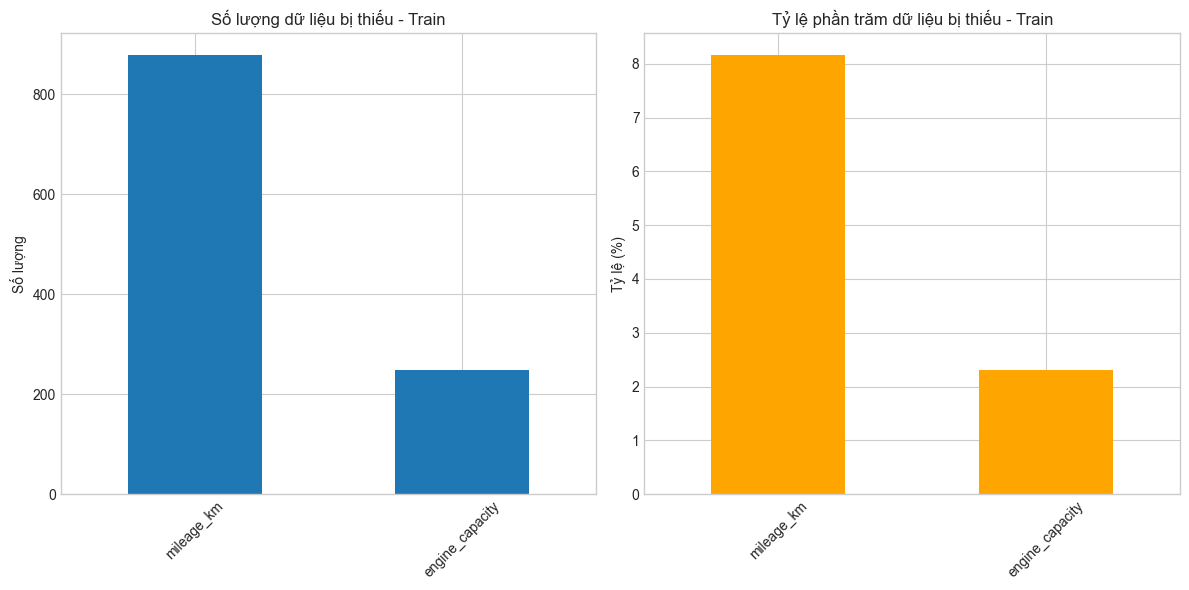

=== PHÂN TÍCH DỮ LIỆU BỊ THIẾU ===

1. Số giá trị bị thiếu trong tập train:
mileage_km         878
engine_capacity    249
dtype: int64

2. Số giá trị bị thiếu trong tập test:
mileage_km         216
engine_capacity     70
dtype: int64

3. Tỷ lệ phần trăm dữ liệu bị thiếu:
mileage_km         8.157577
engine_capacity    2.313481
dtype: float64


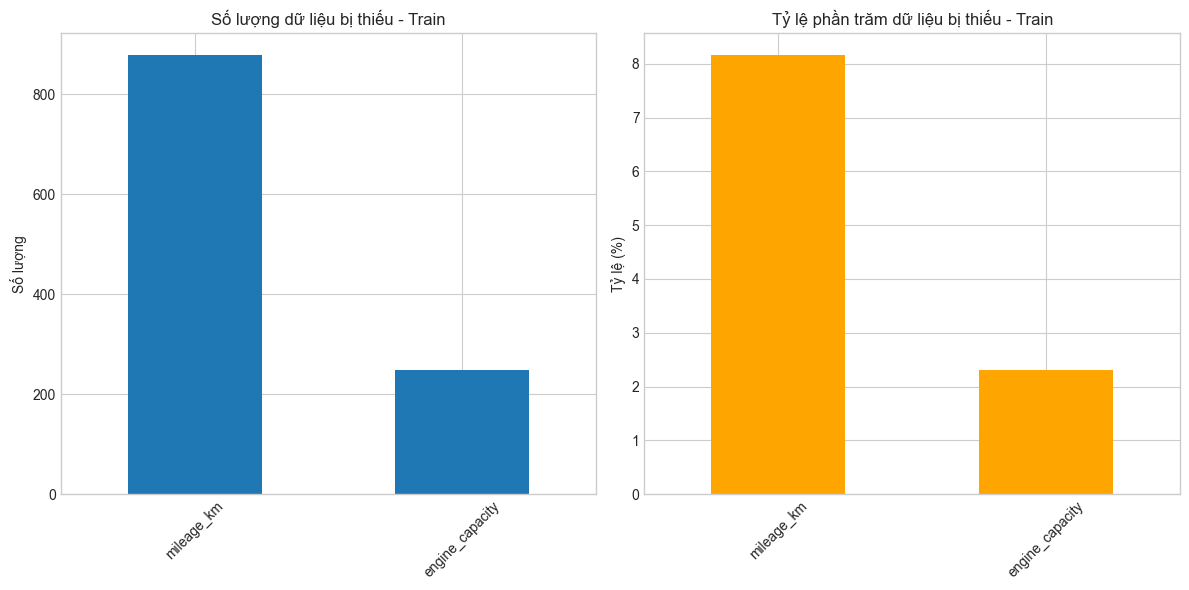


=== XỬ LÝ DỮ LIỆU BỊ THIẾU ===
Các cột số: ['year', 'mileage_km', 'seats', 'doors', 'price_million', 'engine_capacity', 'car_age', 'is_imported']
Các cột phân loại: ['url', 'name', 'brand', 'price', 'origin', 'transmission', 'body_type', 'engine', 'drive', 'exterior_color', 'interior_color', 'condition', 'fuel_type']

4. Xử lý dữ liệu bị thiếu cho các cột số...
  - mileage_km: 878 giá trị thiếu
    Đã thay thế bằng median: 58000.00
  - engine_capacity: 249 giá trị thiếu
    Đã thay thế bằng median: 2.00

5. Xử lý dữ liệu bị thiếu cho các cột phân loại...

6. Xử lý các giá trị ngoại lai...
  - engine_capacity: Đã xử lý 729 giá trị ngoại lai
  - mileage_km: Đã xử lý 407 giá trị ngoại lai
  - year: Đã xử lý 126 giá trị ngoại lai
  - car_age: Đã xử lý 126 giá trị ngoại lai

=== KẾT QUẢ SAU KHI XỬ LÝ ===
7. Số giá trị bị thiếu sau khi xử lý:
Train set:
Series([], dtype: int64)

Test set:
Series([], dtype: int64)

✅ Đã xử lý thành công tất cả dữ liệu bị thiếu!

8. Thống kê mô tả sau khi xử 

In [13]:
# Phân tích dữ liệu bị thiếu trước khi xử lý
print("=== PHÂN TÍCH DỮ LIỆU BỊ THIẾU ===")
print("\n1. Số giá trị bị thiếu trong tập train:")
missing_train = train_df.isnull().sum()
print(missing_train[missing_train > 0])

print("\n2. Số giá trị bị thiếu trong tập test:")
missing_test = test_df.isnull().sum()
print(missing_test[missing_test > 0])

# Hiển thị tỷ lệ phần trăm dữ liệu bị thiếu
print("\n3. Tỷ lệ phần trăm dữ liệu bị thiếu:")
missing_percentage = (missing_train / len(train_df)) * 100
print(missing_percentage[missing_percentage > 0])

# Trực quan hóa dữ liệu bị thiếu
import matplotlib.pyplot as plt
import seaborn as sns

if missing_train.sum() > 0:
    plt.figure(figsize=(12, 6))
    
    # Biểu đồ cột cho số lượng dữ liệu bị thiếu
    plt.subplot(1, 2, 1)
    missing_train[missing_train > 0].plot(kind='bar')
    plt.title('Số lượng dữ liệu bị thiếu - Train')
    plt.ylabel('Số lượng')
    plt.xticks(rotation=45)
    
    # Biểu đồ cột cho tỷ lệ phần trăm dữ liệu bị thiếu
    plt.subplot(1, 2, 2)
    missing_percentage[missing_percentage > 0].plot(kind='bar', color='orange')
    plt.title('Tỷ lệ phần trăm dữ liệu bị thiếu - Train')
    plt.ylabel('Tỷ lệ (%)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Xử lý dữ liệu bị thiếu với các chiến lược khác nhau
print("\n=== XỬ LÝ DỮ LIỆU BỊ THIẾU ===")

# Xác định các cột số và phân loại
numeric_columns = train_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = train_df.select_dtypes(include=['object']).columns.tolist()

print(f"Các cột số: {numeric_columns}")
print(f"Các cột phân loại: {categorical_columns}")

# Xử lý dữ liệu bị thiếu cho các cột số
print("\n4. Xử lý dữ liệu bị thiếu cho các cột số...")
for col in numeric_columns:
    if train_df[col].isnull().sum() > 0:
        print(f"  - {col}: {train_df[col].isnull().sum()} giá trị thiếu")
        # Sử dụng median cho các cột số
        median_value = train_df[col].median()
        train_df[col].fillna(median_value, inplace=True)
        test_df[col].fillna(median_value, inplace=True)
        print(f"    Đã thay thế bằng median: {median_value:.2f}")

# Xử lý dữ liệu bị thiếu cho các cột phân loại
print("\n5. Xử lý dữ liệu bị thiếu cho các cột phân loại...")
for col in categorical_columns:
    if train_df[col].isnull().sum() > 0:
        print(f"  - {col}: {train_df[col].isnull().sum()} giá trị thiếu")
        # Sử dụng mode (giá trị xuất hiện nhiều nhất) cho các cột phân loại
        mode_value = train_df[col].mode()[0] if not train_df[col].mode().empty else 'Unknown'
        train_df[col].fillna(mode_value, inplace=True)
        test_df[col].fillna(mode_value, inplace=True)
        print(f"    Đã thay thế bằng mode: '{mode_value}'")

# Xử lý các giá trị ngoại lai
print("\n6. Xử lý các giá trị ngoại lai...")
numeric_cols_for_outliers = ['engine_capacity', 'mileage_km', 'year', 'car_age']
numeric_cols_for_outliers = [col for col in numeric_cols_for_outliers if col in train_df.columns]

for col in numeric_cols_for_outliers:
    if col in train_df.columns:
        Q1 = train_df[col].quantile(0.25)
        Q3 = train_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_before = ((train_df[col] < lower_bound) | (train_df[col] > upper_bound)).sum()
        train_df[col] = train_df[col].clip(lower_bound, upper_bound)
        test_df[col] = test_df[col].clip(lower_bound, upper_bound)
        
        print(f"  - {col}: Đã xử lý {outliers_before} giá trị ngoại lai")

# Kiểm tra kết quả cuối cùng
print("\n=== KẾT QUẢ SAU KHI XỬ LÝ ===")
print("7. Số giá trị bị thiếu sau khi xử lý:")
final_missing_train = train_df.isnull().sum()
final_missing_test = test_df.isnull().sum()

print("Train set:")
print(final_missing_train[final_missing_train > 0])
print("\nTest set:")
print(final_missing_test[final_missing_test > 0])

if final_missing_train.sum() == 0 and final_missing_test.sum() == 0:
    print("\n✅ Đã xử lý thành công tất cả dữ liệu bị thiếu!")
else:
    print(f"\n⚠️ Vẫn còn {final_missing_train.sum() + final_missing_test.sum()} giá trị bị thiếu")

# Hiển thị thống kê mô tả sau khi xử lý
print("\n8. Thống kê mô tả sau khi xử lý:")
print(train_df[numeric_columns].describe())

=== PHÂN TÍCH CHẤT LƯỢNG DỮ LIỆU ===

1. Kiểm tra dữ liệu trùng lặp:
  - Train set: 663 dòng trùng lặp
  - Test set: 52 dòng trùng lặp

2. Kiểm tra các giá trị bất thường:
  - year:
    Min: 2007.00, Max: 2025.00, Mean: 2018.99, Std: 4.24
  - mileage_km:
    Min: 1.00, Max: 155000.00, Mean: 60603.25, Std: 38377.07
  - seats:
    Min: 0.00, Max: 47.00, Mean: 5.59, Std: 1.65
  - doors:
    Min: 2.00, Max: 5.00, Mean: 4.63, Std: 0.55
  - price_million:
    Min: 32.00, Max: 26999.00, Mean: 1377.10, Std: 1861.43
  - engine_capacity:
    Min: 0.25, Max: 3.85, Mean: 2.16, Std: 0.70
  - car_age:
    Min: 0.00, Max: 18.00, Mean: 6.01, Std: 4.24
    Có 304 giá trị bằng 0
  - is_imported:
    Min: 0.00, Max: 1.00, Mean: 0.47, Std: 0.50

3. Kiểm tra tính nhất quán của dữ liệu:
  - car_age: 0 giá trị không hợp lý (âm hoặc > 50 năm)
  - year: 0 giá trị không hợp lý (< 1900 hoặc > 2025)
  - mileage_km: 0 giá trị không hợp lý (< 0 hoặc > 1,000,000 km)

4. Phân tích phân bố dữ liệu:


=== PHÂN TÍCH CHẤT LƯỢNG DỮ LIỆU ===

1. Kiểm tra dữ liệu trùng lặp:
  - Train set: 663 dòng trùng lặp
  - Test set: 52 dòng trùng lặp

2. Kiểm tra các giá trị bất thường:
  - year:
    Min: 2007.00, Max: 2025.00, Mean: 2018.99, Std: 4.24
  - mileage_km:
    Min: 1.00, Max: 155000.00, Mean: 60603.25, Std: 38377.07
  - seats:
    Min: 0.00, Max: 47.00, Mean: 5.59, Std: 1.65
  - doors:
    Min: 2.00, Max: 5.00, Mean: 4.63, Std: 0.55
  - price_million:
    Min: 32.00, Max: 26999.00, Mean: 1377.10, Std: 1861.43
  - engine_capacity:
    Min: 0.25, Max: 3.85, Mean: 2.16, Std: 0.70
  - car_age:
    Min: 0.00, Max: 18.00, Mean: 6.01, Std: 4.24
    Có 304 giá trị bằng 0
  - is_imported:
    Min: 0.00, Max: 1.00, Mean: 0.47, Std: 0.50

3. Kiểm tra tính nhất quán của dữ liệu:
  - car_age: 0 giá trị không hợp lý (âm hoặc > 50 năm)
  - year: 0 giá trị không hợp lý (< 1900 hoặc > 2025)
  - mileage_km: 0 giá trị không hợp lý (< 0 hoặc > 1,000,000 km)

4. Phân tích phân bố dữ liệu:


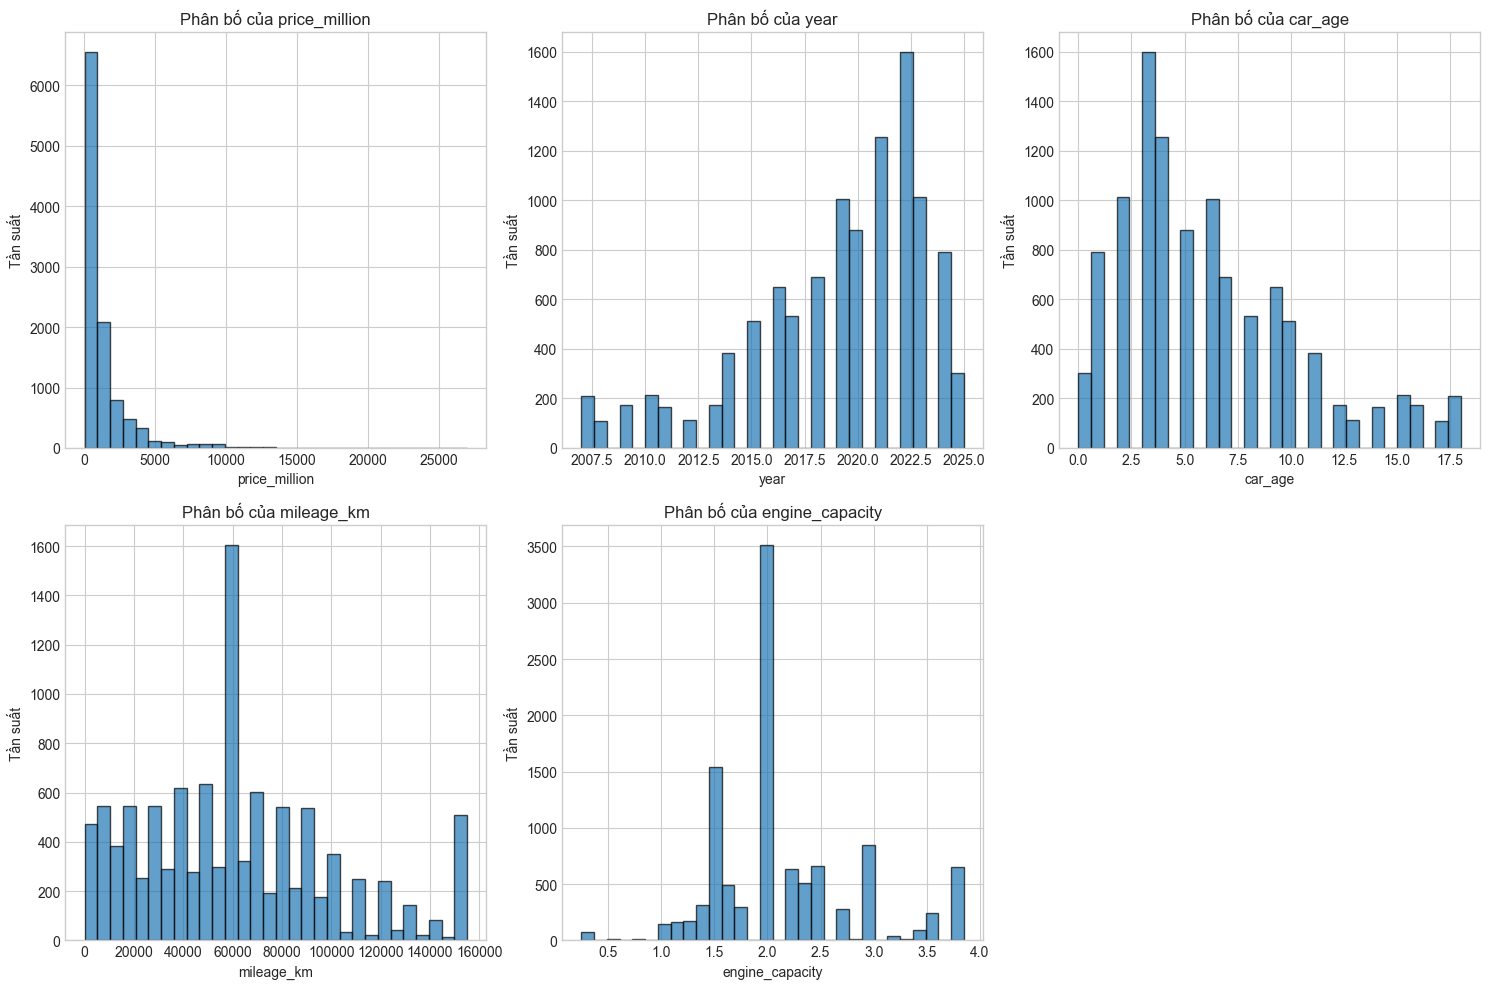


5. Tóm tắt chất lượng dữ liệu:
  - Tổng số mẫu train: 10,763
  - Tổng số mẫu test: 2,690
  - Số đặc trưng: 21
  - Dữ liệu bị thiếu: 0
  - Dữ liệu trùng lặp: 715
  - Không còn dữ liệu bị thiếu

 Hoàn thành phân tích chất lượng dữ liệu!


In [15]:
# Phân tích chi tiết về chất lượng dữ liệu sau khi xử lý
print("=== PHÂN TÍCH CHẤT LƯỢNG DỮ LIỆU ===")

# 1. Kiểm tra dữ liệu trùng lặp
print("\n1. Kiểm tra dữ liệu trùng lặp:")
duplicates_train = train_df.duplicated().sum()
duplicates_test = test_df.duplicated().sum()
print(f"  - Train set: {duplicates_train} dòng trùng lặp")
print(f"  - Test set: {duplicates_test} dòng trùng lặp")

# 2. Kiểm tra các giá trị bất thường trong dữ liệu số
print("\n2. Kiểm tra các giá trị bất thường:")
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if col in train_df.columns:
        min_val = train_df[col].min()
        max_val = train_df[col].max()
        mean_val = train_df[col].mean()
        std_val = train_df[col].std()
        
        # Kiểm tra giá trị âm không hợp lý
        negative_count = (train_df[col] < 0).sum()
        
        # Kiểm tra giá trị 0 không hợp lý (cho một số cột)
        zero_count = (train_df[col] == 0).sum()
        
        print(f"  - {col}:")
        print(f"    Min: {min_val:.2f}, Max: {max_val:.2f}, Mean: {mean_val:.2f}, Std: {std_val:.2f}")
        if negative_count > 0:
            print(f"    Có {negative_count} giá trị âm")
        if zero_count > 0 and col in ['year', 'engine_capacity', 'car_age']:
            print(f"    Có {zero_count} giá trị bằng 0")

# 3. Kiểm tra tính nhất quán của dữ liệu
print("\n3. Kiểm tra tính nhất quán của dữ liệu:")

# Kiểm tra car_age có hợp lý không (không âm, không quá lớn)
if 'car_age' in train_df.columns:
    invalid_age = (train_df['car_age'] < 0) | (train_df['car_age'] > 50)
    print(f"  - car_age: {invalid_age.sum()} giá trị không hợp lý (âm hoặc > 50 năm)")

# Kiểm tra year có hợp lý không
if 'year' in train_df.columns:
    invalid_year = (train_df['year'] < 1900) | (train_df['year'] > 2025)
    print(f"  - year: {invalid_year.sum()} giá trị không hợp lý (< 1900 hoặc > 2025)")

# Kiểm tra mileage có hợp lý không
if 'mileage_km' in train_df.columns:
    invalid_mileage = (train_df['mileage_km'] < 0) | (train_df['mileage_km'] > 1000000)
    print(f"  - mileage_km: {invalid_mileage.sum()} giá trị không hợp lý (< 0 hoặc > 1,000,000 km)")

# 4. Phân tích phân bố dữ liệu sau khi xử lý
print("\n4. Phân tích phân bố dữ liệu:")

# Vẽ biểu đồ phân bố cho các cột số quan trọng
important_numeric_cols = ['price_million', 'year', 'car_age', 'mileage_km', 'engine_capacity']
available_cols = [col for col in important_numeric_cols if col in train_df.columns]

if available_cols:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, col in enumerate(available_cols[:6]):  # Chỉ lấy 6 cột đầu tiên
        if i < len(axes):
            axes[i].hist(train_df[col].dropna(), bins=30, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Phân bố của {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Tần suất')
    
    # Ẩn các subplot không sử dụng
    for i in range(len(available_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# 5. Tóm tắt chất lượng dữ liệu
print("\n5. Tóm tắt chất lượng dữ liệu:")
print(f"  - Tổng số mẫu train: {len(train_df):,}")
print(f"  - Tổng số mẫu test: {len(test_df):,}")
print(f"  - Số đặc trưng: {train_df.shape[1]}")
print(f"  - Dữ liệu bị thiếu: {train_df.isnull().sum().sum() + test_df.isnull().sum().sum()}")
print(f"  - Dữ liệu trùng lặp: {duplicates_train + duplicates_test}")

if train_df.isnull().sum().sum() == 0 and test_df.isnull().sum().sum() == 0:
    print("  - Không còn dữ liệu bị thiếu")
else:
    print("  - Vẫn còn dữ liệu bị thiếu")

print("\n Hoàn thành phân tích chất lượng dữ liệu!")


### 2.4 Chuẩn bị dữ liệu cho phân tích

In [16]:
# Chọn các đặc trưng và biến mục tiêu
feature_cols = ['year', 'engine_capacity', 'car_age', 'is_imported', 'mileage_km', 'seats', 'doors']
categorical_cols = ['brand', 'body_type', 'fuel_type', 'transmission', 'drive', 'exterior_color', 'interior_color', 'condition']
target_col = 'price_million'

# Kiểm tra xem các cột có tồn tại không và lọc dữ liệu
feature_cols = [col for col in feature_cols if col in train_df.columns]
categorical_cols = [col for col in categorical_cols if col in train_df.columns]

# Mã hóa các đặc trưng phân loại
X_train = train_df[feature_cols + categorical_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols + categorical_cols]
y_test = test_df[target_col]

# Chuyển đổi categorical features sang one-hot encoding
X_train_encoded = encode_categorical_features(X_train, categorical_cols, method='onehot')
X_test_encoded = encode_categorical_features(X_test, categorical_cols, method='onehot')

print(f"Số đặc trưng sau khi mã hóa: {X_train_encoded.shape[1]}")
print(f"Các cột số: {feature_cols}")
print(f"Các cột phân loại: {categorical_cols}")

Số đặc trưng sau khi mã hóa: 123
Các cột số: ['year', 'engine_capacity', 'car_age', 'is_imported', 'mileage_km', 'seats', 'doors']
Các cột phân loại: ['brand', 'body_type', 'fuel_type', 'transmission', 'drive', 'exterior_color', 'interior_color', 'condition']


## 3. Phân tích thống kê dữ liệu

Thống kê cho các đặc trưng số:
               year  engine_capacity       car_age   is_imported     mileage_km         seats         doors
count  10763.000000     10763.000000  10763.000000  10763.000000   10763.000000  10763.000000  10763.000000
mean    2018.988572         2.158051      6.011428      0.469107   60603.252067      5.586454      4.628078
std        4.240161         0.701198      4.240161      0.499068   38377.067906      1.652497      0.553259
min     2007.000000         0.250000      0.000000      0.000000       1.000000      0.000000      2.000000
25%     2016.000000         1.600000      3.000000      0.000000   30000.000000      5.000000      4.000000
50%     2020.000000         2.000000      5.000000      0.000000   58000.000000      5.000000      5.000000
75%     2022.000000         2.500000      9.000000      1.000000   80000.000000      7.000000      5.000000
max     2025.000000         3.850000     18.000000      1.000000  155000.000000     47.000000      5.0000

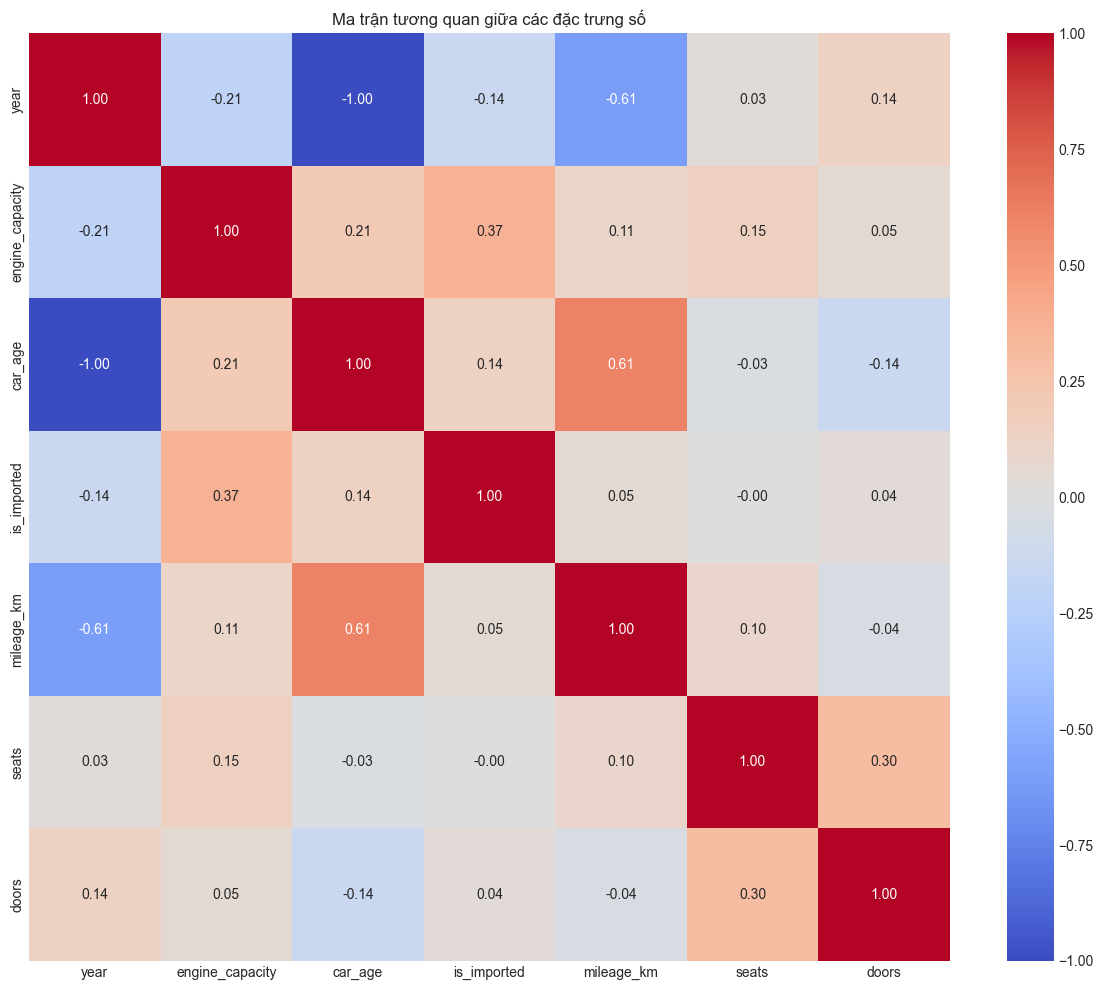

Thống kê cho các đặc trưng số:
               year  engine_capacity       car_age   is_imported     mileage_km         seats         doors
count  10763.000000     10763.000000  10763.000000  10763.000000   10763.000000  10763.000000  10763.000000
mean    2018.988572         2.158051      6.011428      0.469107   60603.252067      5.586454      4.628078
std        4.240161         0.701198      4.240161      0.499068   38377.067906      1.652497      0.553259
min     2007.000000         0.250000      0.000000      0.000000       1.000000      0.000000      2.000000
25%     2016.000000         1.600000      3.000000      0.000000   30000.000000      5.000000      4.000000
50%     2020.000000         2.000000      5.000000      0.000000   58000.000000      5.000000      5.000000
75%     2022.000000         2.500000      9.000000      1.000000   80000.000000      7.000000      5.000000
max     2025.000000         3.850000     18.000000      1.000000  155000.000000     47.000000      5.0000

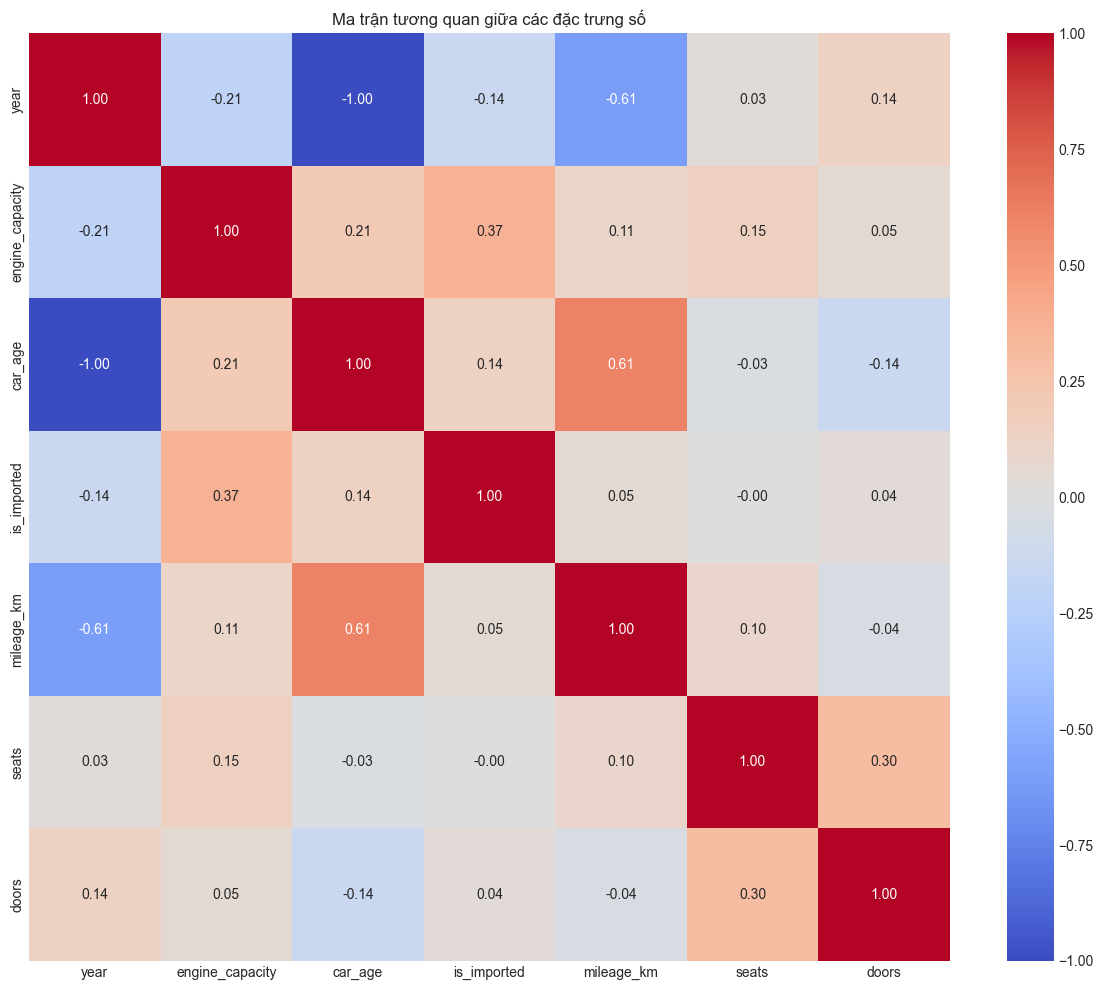

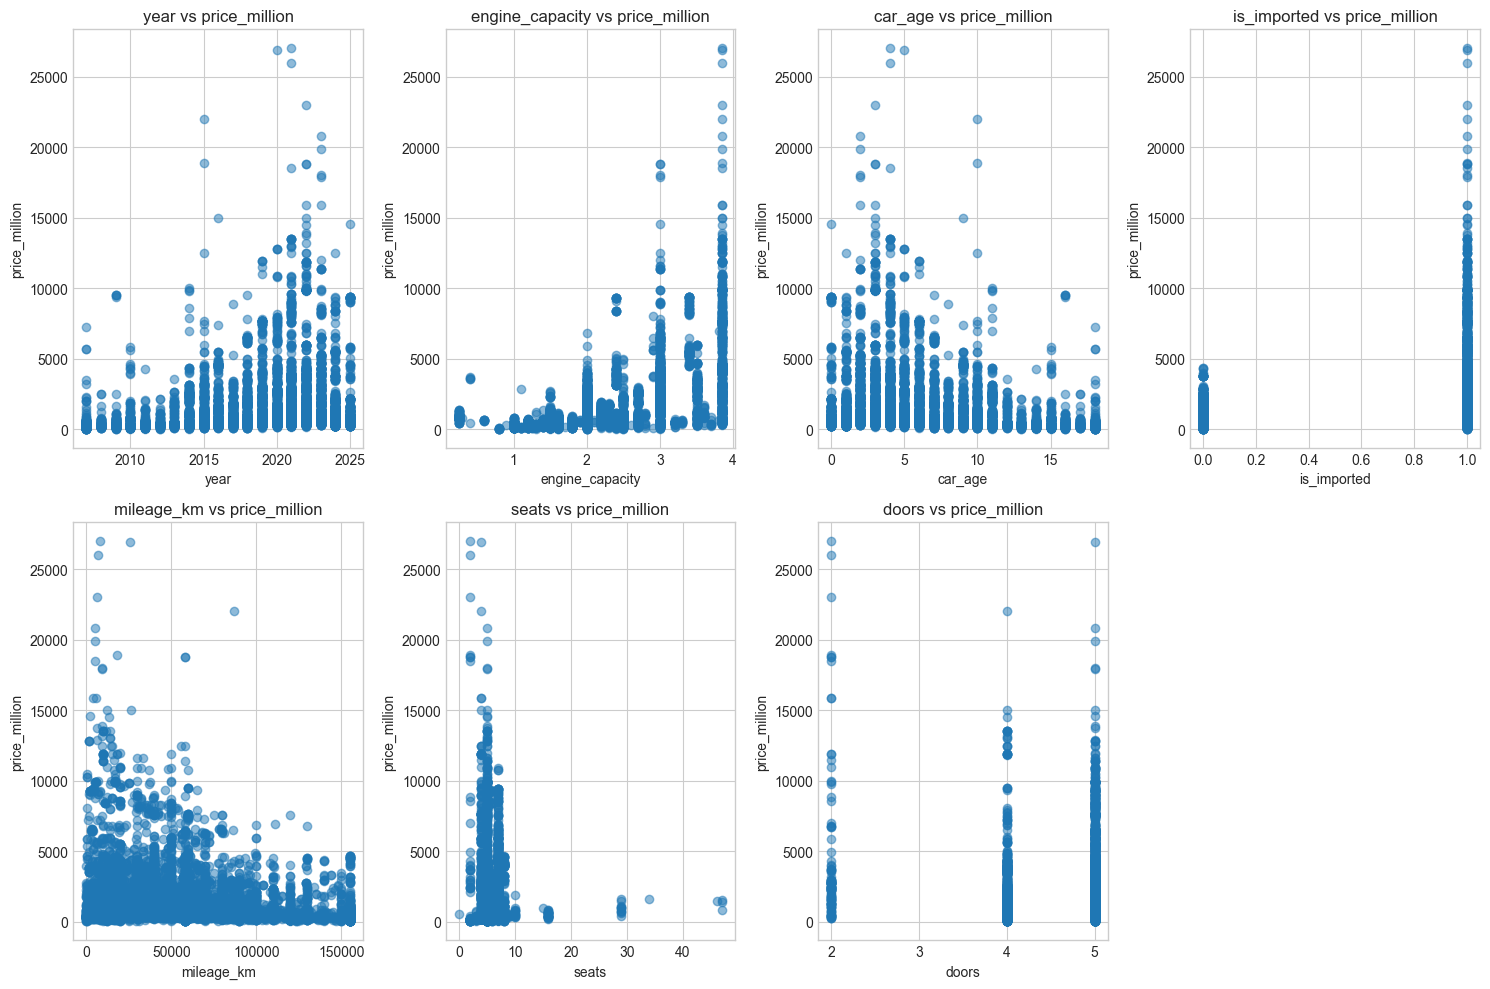

In [17]:
# Phân tích thống kê cho các đặc trưng số
numeric_stats = X_train[feature_cols].describe()
print("Thống kê cho các đặc trưng số:")
print(numeric_stats)

# Hiển thị tương quan giữa các đặc trưng số
plt.figure(figsize=(12, 10))
correlation_matrix = X_train[feature_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Ma trận tương quan giữa các đặc trưng số')
plt.tight_layout()
plt.show()

# Phân tích mối quan hệ giữa các đặc trưng số và giá xe
plt.figure(figsize=(15, 10))
for i, col in enumerate(feature_cols):
    plt.subplot(2, 4, i+1)
    plt.scatter(train_df[col], train_df[target_col], alpha=0.5)
    plt.title(f'{col} vs {target_col}')
    plt.xlabel(col)
    plt.ylabel(target_col)
plt.tight_layout()
plt.show()

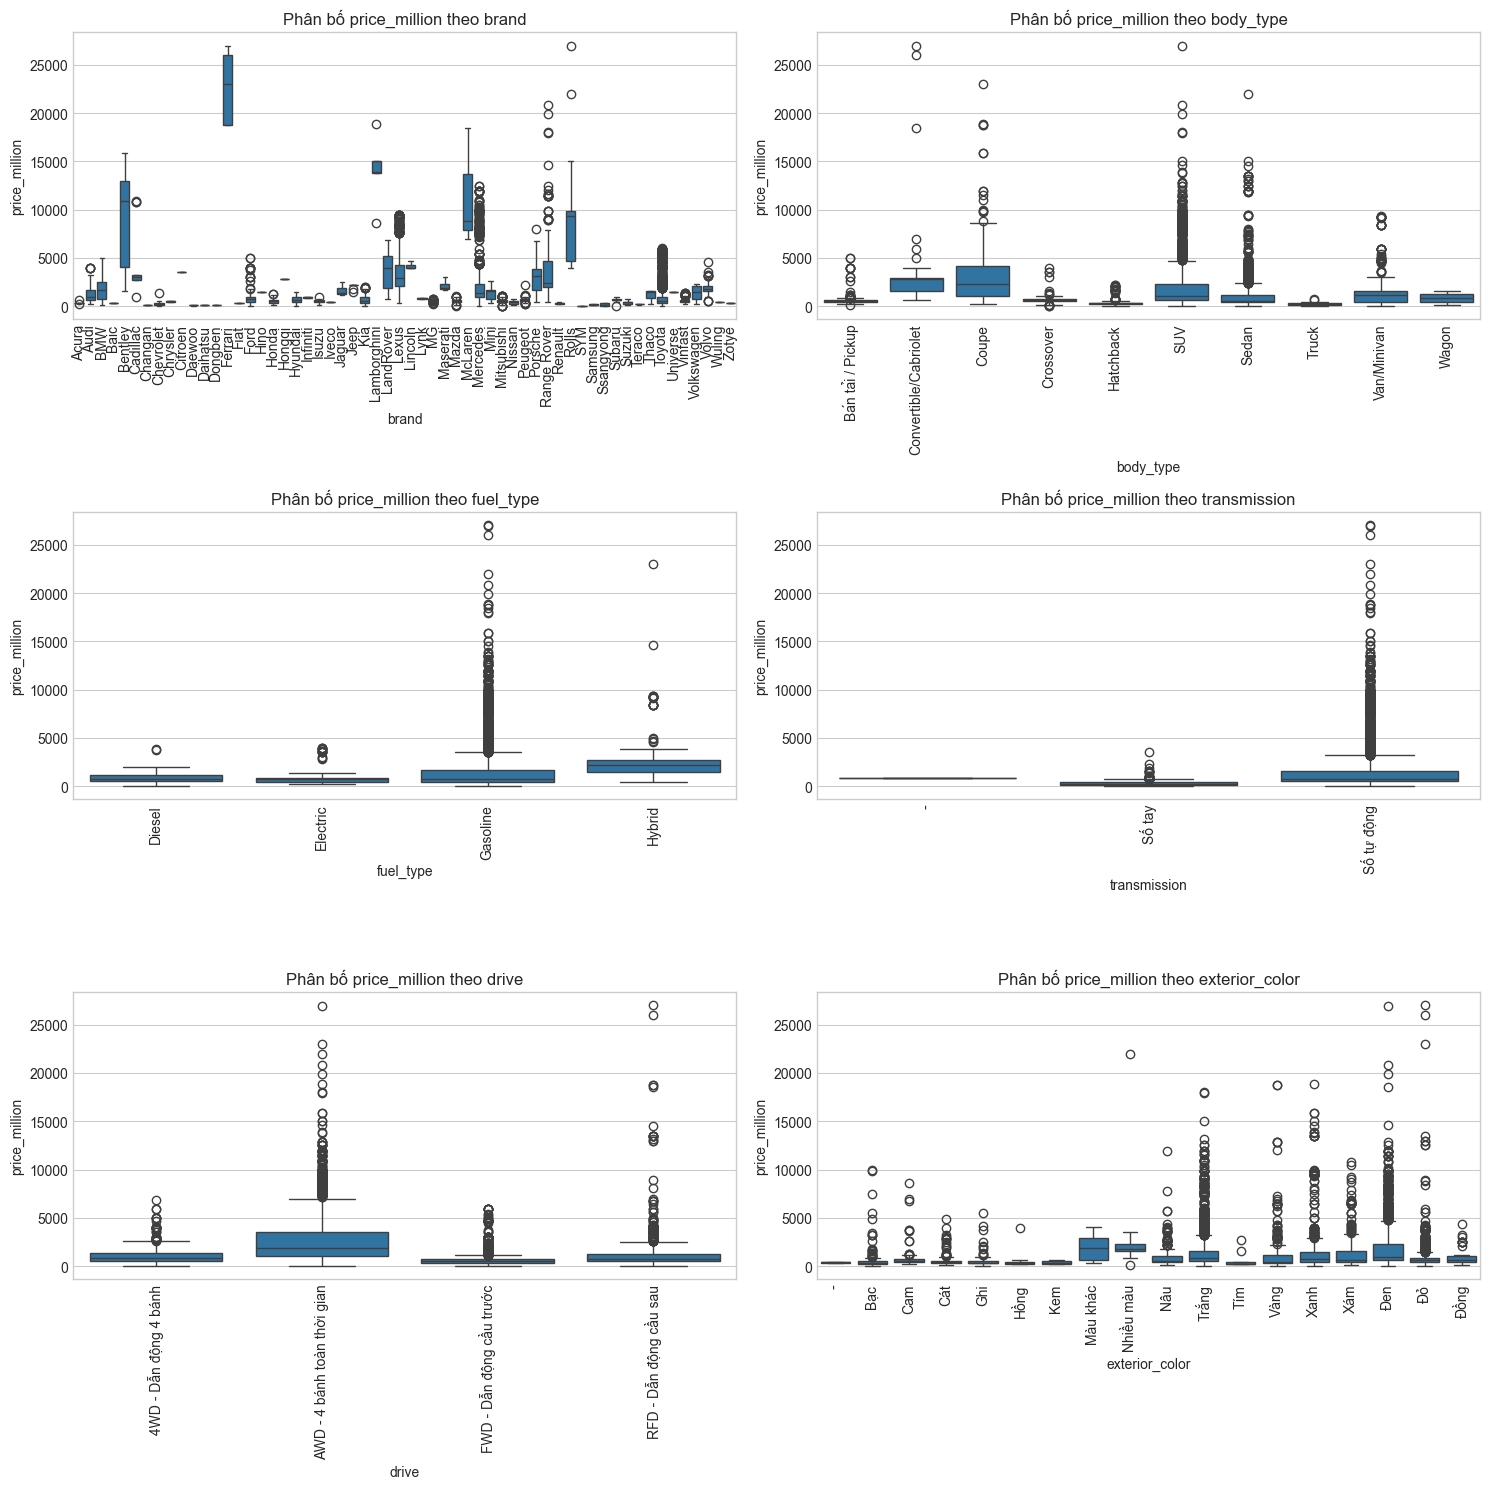

In [18]:
# Phân tích phân bố của giá xe theo các đặc trưng phân loại
plt.figure(figsize=(15, 15))
for i, col in enumerate(categorical_cols[:6]):  # Chỉ lấy 6 đặc trưng đầu tiên để hiển thị
    plt.subplot(3, 2, i+1)
    sns.boxplot(x=col, y=target_col, data=train_df.sort_values(col))
    plt.title(f'Phân bố {target_col} theo {col}')
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [20]:
# SỬA LỖI: Xử lý vấn đề tên cột không khớp giữa train và test set
print("=== SỬA LỖI TÊN CỘT KHÔNG KHỚP ===")

# Kiểm tra xem có lỗi tên cột không
if 'X_train_encoded' in locals() and 'X_test_encoded' in locals():
    train_cols = set(X_train_encoded.columns)
    test_cols = set(X_test_encoded.columns)
    
    missing_in_test = train_cols - test_cols
    missing_in_train = test_cols - train_cols
    
    print(f"1. Kiểm tra tên cột:")
    print(f"   - Cột có trong train nhưng không có trong test: {len(missing_in_test)}")
    print(f"   - Cột có trong test nhưng không có trong train: {len(missing_in_train)}")
    
    if missing_in_test or missing_in_train:
        print("  Phát hiện tên cột không khớp, đang sửa...")
        
        # Thêm cột thiếu vào test set với giá trị 0
        for col in missing_in_test:
            X_test_encoded[col] = 0
        
        # Thêm cột thiếu vào train set với giá trị 0  
        for col in missing_in_train:
            X_train_encoded[col] = 0
        
        # Sắp xếp cột theo thứ tự giống nhau
        all_cols = sorted(list(train_cols.union(test_cols)))
        X_train_encoded = X_train_encoded.reindex(columns=all_cols, fill_value=0)
        X_test_encoded = X_test_encoded.reindex(columns=all_cols, fill_value=0)
        
        print(" Đã sửa xong tên cột không khớp")
    else:
        print(" Tên cột đã khớp")
else:
    print(" Dữ liệu chưa được mã hóa. Đang chuẩn bị dữ liệu...")
    
    # Chọn các đặc trưng và biến mục tiêu
    feature_cols = ['year', 'engine_capacity', 'car_age', 'is_imported', 'mileage_km', 'seats', 'doors']
    categorical_cols = ['brand', 'body_type', 'fuel_type', 'transmission', 'drive', 'exterior_color', 'interior_color', 'condition']
    target_col = 'price_million'
    
    # Kiểm tra xem các cột có tồn tại không và lọc dữ liệu
    feature_cols = [col for col in feature_cols if col in train_df.columns]
    categorical_cols = [col for col in categorical_cols if col in train_df.columns]
    
    # Mã hóa các đặc trưng phân loại
    X_train = train_df[feature_cols + categorical_cols]
    y_train = train_df[target_col]
    X_test = test_df[feature_cols + categorical_cols]
    y_test = test_df[target_col]
    
    # Chuyển đổi categorical features sang one-hot encoding
    X_train_encoded = encode_categorical_features(X_train, categorical_cols, method='onehot')
    X_test_encoded = encode_categorical_features(X_test, categorical_cols, method='onehot')
    
    # Xử lý tên cột không khớp
    train_cols = set(X_train_encoded.columns)
    test_cols = set(X_test_encoded.columns)
    
    missing_in_test = train_cols - test_cols
    missing_in_train = test_cols - train_cols
    
    # Thêm cột thiếu với giá trị 0
    for col in missing_in_test:
        X_test_encoded[col] = 0
    for col in missing_in_train:
        X_train_encoded[col] = 0
    
    # Sắp xếp cột theo thứ tự giống nhau
    all_cols = sorted(list(train_cols.union(test_cols)))
    X_train_encoded = X_train_encoded.reindex(columns=all_cols, fill_value=0)
    X_test_encoded = X_test_encoded.reindex(columns=all_cols, fill_value=0)
    
    print(f"Đã chuẩn bị dữ liệu: {X_train_encoded.shape[1]} đặc trưng")

# Kiểm tra dữ liệu NaN và vô hạn
print(f"\n2. Kiểm tra dữ liệu:")
print(f"   - X_train_encoded: {X_train_encoded.isnull().sum().sum()} NaN, {np.isinf(X_train_encoded.select_dtypes(include=[np.number])).sum().sum()} vô hạn")
print(f"   - X_test_encoded: {X_test_encoded.isnull().sum().sum()} NaN, {np.isinf(X_test_encoded.select_dtypes(include=[np.number])).sum().sum()} vô hạn")

# Xử lý dữ liệu NaN và vô hạn
X_train_encoded = X_train_encoded.replace([np.inf, -np.inf], np.nan)
X_test_encoded = X_test_encoded.replace([np.inf, -np.inf], np.nan)
X_train_encoded = X_train_encoded.fillna(0)
X_test_encoded = X_test_encoded.fillna(0)

print("   Đã xử lý dữ liệu NaN và vô hạn")

print(f"\n3. Kích thước dữ liệu cuối cùng:")
print(f"   - X_train_encoded: {X_train_encoded.shape}")
print(f"   - X_test_encoded: {X_test_encoded.shape}")
print(f"   - Tên cột khớp: {list(X_train_encoded.columns) == list(X_test_encoded.columns)}")

print("\n Hoàn thành sửa lỗi tên cột!")


=== SỬA LỖI TÊN CỘT KHÔNG KHỚP ===
1. Kiểm tra tên cột:
   - Cột có trong train nhưng không có trong test: 0
   - Cột có trong test nhưng không có trong train: 0
 Tên cột đã khớp

2. Kiểm tra dữ liệu:
   - X_train_encoded: 0 NaN, 0 vô hạn
   - X_test_encoded: 0 NaN, 0 vô hạn
   Đã xử lý dữ liệu NaN và vô hạn

3. Kích thước dữ liệu cuối cùng:
   - X_train_encoded: (10763, 125)
   - X_test_encoded: (2690, 125)
   - Tên cột khớp: True

 Hoàn thành sửa lỗi tên cột!


=== THỰC HIỆN PCA ===
1. Chuẩn hóa dữ liệu...
   Chuẩn hóa thành công
  - Train scaled: (10763, 125)
  - Test scaled: (2690, 125)

2. Áp dụng PCA...
   PCA thành công với 100 thành phần!
   - Tỉ lệ phương sai giữ lại: 0.9536
   - Giảm chiều từ 125 xuống 100

3. Vẽ biểu đồ phương sai giải thích...


=== THỰC HIỆN PCA ===
1. Chuẩn hóa dữ liệu...
   Chuẩn hóa thành công
  - Train scaled: (10763, 125)
  - Test scaled: (2690, 125)

2. Áp dụng PCA...
   PCA thành công với 100 thành phần!
   - Tỉ lệ phương sai giữ lại: 0.9536
   - Giảm chiều từ 125 xuống 100

3. Vẽ biểu đồ phương sai giải thích...


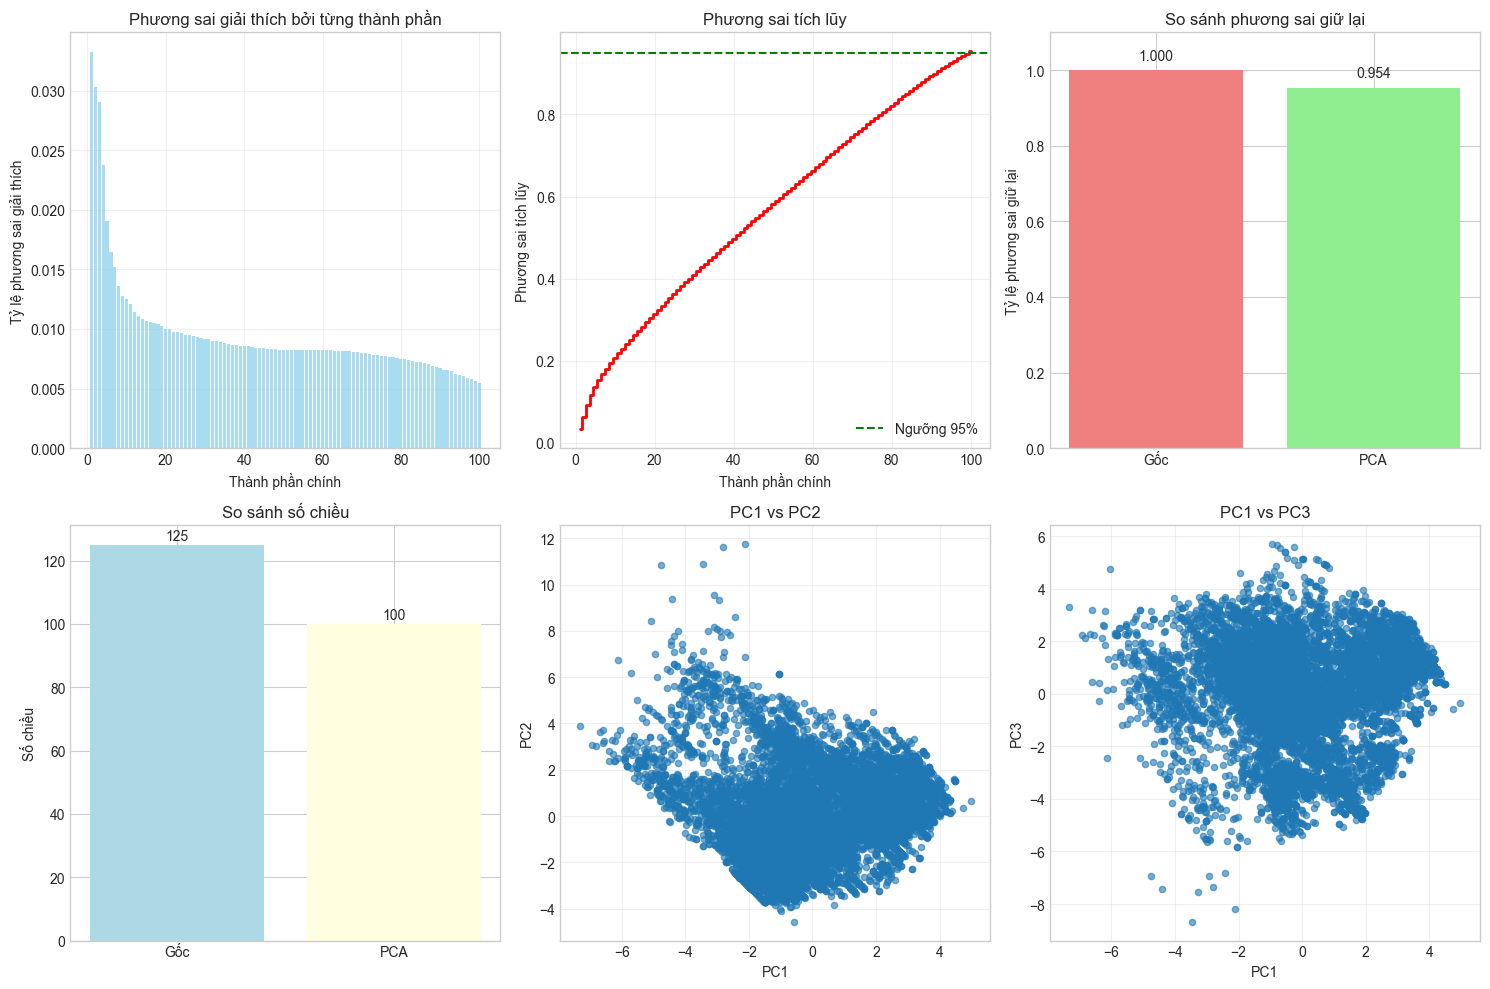


 hoàn thành PCA!
   - Số thành phần chính: 100
   - Phương sai giữ lại: 0.9536
   - Giảm chiều: 125 → 100


In [21]:
# PCA IMPLEMENTATION - Đã sửa lỗi
print("=== THỰC HIỆN PCA ===")

# Chuẩn hóa dữ liệu trước khi thực hiện PCA
print("1. Chuẩn hóa dữ liệu...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

print(f"   Chuẩn hóa thành công")
print(f"  - Train scaled: {X_train_scaled.shape}")
print(f"  - Test scaled: {X_test_scaled.shape}")

# Áp dụng PCA
print("\n2. Áp dụng PCA...")
try:
    # Thử với 95% phương sai trước
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    n_components = pca.n_components_
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    print(f"   PCA thành công với {n_components} thành phần!")
    print(f"   - Tỉ lệ phương sai giữ lại: {sum(explained_variance_ratio):.4f}")
    print(f"   - Giảm chiều từ {X_train_scaled.shape[1]} xuống {X_train_pca.shape[1]}")
    
except Exception as e:
    print(f"   Lỗi với 95% phương sai: {str(e)}")
    print("   Đang thử với số thành phần cố định...")
    
    # Thử với số thành phần cố định
    min_components = min(X_train_scaled.shape[0], X_train_scaled.shape[1])
    n_components_fixed = min(15, min_components - 1)  # Giữ lại 15 thành phần hoặc ít hơn
    
    pca = PCA(n_components=n_components_fixed)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    n_components = pca.n_components_
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    print(f"   PCA thành công với {n_components} thành phần!")
    print(f"   - Tỉ lệ phương sai giữ lại: {sum(explained_variance_ratio):.4f}")

# Vẽ biểu đồ phương sai giải thích
print("\n3. Vẽ biểu đồ phương sai giải thích...")
plt.figure(figsize=(15, 10))

# Biểu đồ phương sai giải thích
plt.subplot(2, 3, 1)
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, color='skyblue')
plt.xlabel('Thành phần chính')
plt.ylabel('Tỷ lệ phương sai giải thích')
plt.title('Phương sai giải thích bởi từng thành phần')
plt.grid(True, alpha=0.3)

# Biểu đồ phương sai tích lũy
plt.subplot(2, 3, 2)
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', color='red', linewidth=2)
plt.axhline(y=0.95, linestyle='--', color='green', label='Ngưỡng 95%')
plt.xlabel('Thành phần chính')
plt.ylabel('Phương sai tích lũy')
plt.title('Phương sai tích lũy')
plt.legend()
plt.grid(True, alpha=0.3)

# Biểu đồ so sánh số chiều
plt.subplot(2, 3, 3)
dimensions = ['Gốc', 'PCA']
variance_retained = [1.0, sum(explained_variance_ratio)]
plt.bar(dimensions, variance_retained, color=['lightcoral', 'lightgreen'])
plt.ylabel('Tỷ lệ phương sai giữ lại')
plt.title('So sánh phương sai giữ lại')
plt.ylim(0, 1.1)
for i, v in enumerate(variance_retained):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

# Biểu đồ số chiều
plt.subplot(2, 3, 4)
dimensions = ['Gốc', 'PCA']
n_dims = [X_train_scaled.shape[1], X_train_pca.shape[1]]
plt.bar(dimensions, n_dims, color=['lightblue', 'lightyellow'])
plt.ylabel('Số chiều')
plt.title('So sánh số chiều')
for i, v in enumerate(n_dims):
    plt.text(i, v + 0.5, f'{v}', ha='center', va='bottom')

# Biểu đồ tương quan giữa PC1 và PC2
plt.subplot(2, 3, 5)
if X_train_pca.shape[1] >= 2:
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.6, s=20)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PC1 vs PC2')
    plt.grid(True, alpha=0.3)

# Biểu đồ tương quan giữa PC1 và PC3 (nếu có)
plt.subplot(2, 3, 6)
if X_train_pca.shape[1] >= 3:
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 2], alpha=0.6, s=20)
    plt.xlabel('PC1')
    plt.ylabel('PC3')
    plt.title('PC1 vs PC3')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Không đủ thành phần\nđể hiển thị PC3', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('PC1 vs PC3')

plt.tight_layout()
plt.show()

print(f"\n hoàn thành PCA!")
print(f"   - Số thành phần chính: {n_components}")
print(f"   - Phương sai giữ lại: {sum(explained_variance_ratio):.4f}")
print(f"   - Giảm chiều: {X_train_scaled.shape[1]} → {X_train_pca.shape[1]}")


## 4. Giảm chiều dữ liệu

### 4.1 Phương pháp 1: PCA (Principal Component Analysis)

Số thành phần chính giữ lại: 100
Tỉ lệ phương sai giữ lại: 0.9536
Giảm chiều dữ liệu từ 125 xuống 100


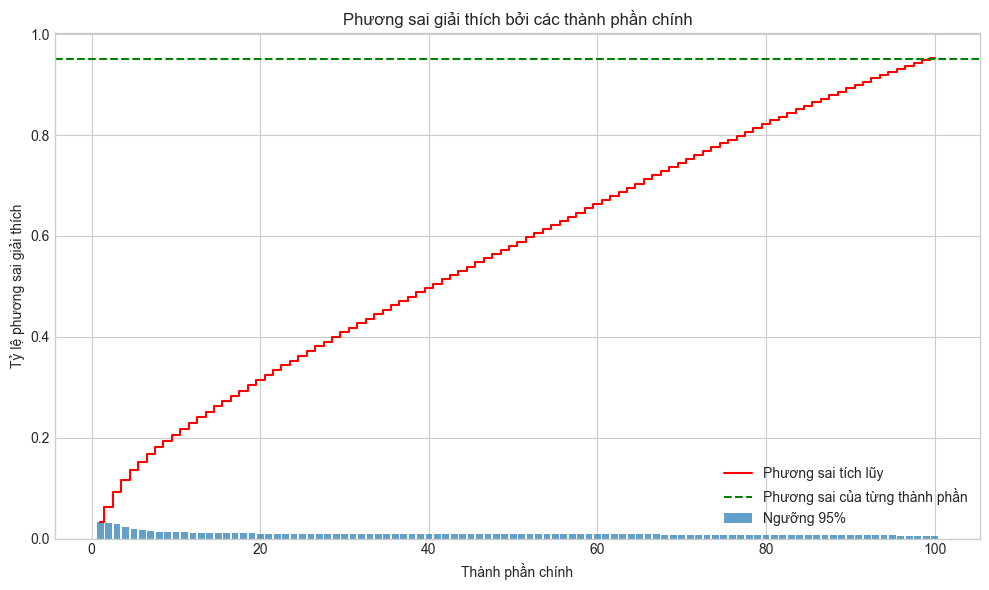

In [22]:
# Chuẩn hóa dữ liệu trước khi thực hiện PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Áp dụng PCA
pca = PCA(n_components=0.95)  # Giữ 95% phương sai
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Hiển thị kết quả
n_components = pca.n_components_
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print(f"Số thành phần chính giữ lại: {n_components}")
print(f"Tỉ lệ phương sai giữ lại: {sum(explained_variance_ratio):.4f}")
print(f"Giảm chiều dữ liệu từ {X_train_scaled.shape[1]} xuống {X_train_pca.shape[1]}")

# Vẽ biểu đồ phương sai giải thích
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7)
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', color='red')
plt.axhline(y=0.95, linestyle='--', color='green')
plt.xlabel('Thành phần chính')
plt.ylabel('Tỷ lệ phương sai giải thích')
plt.title('Phương sai giải thích bởi các thành phần chính')
plt.legend(['Phương sai tích lũy', 'Phương sai của từng thành phần', 'Ngưỡng 95%'])
plt.tight_layout()
plt.show()

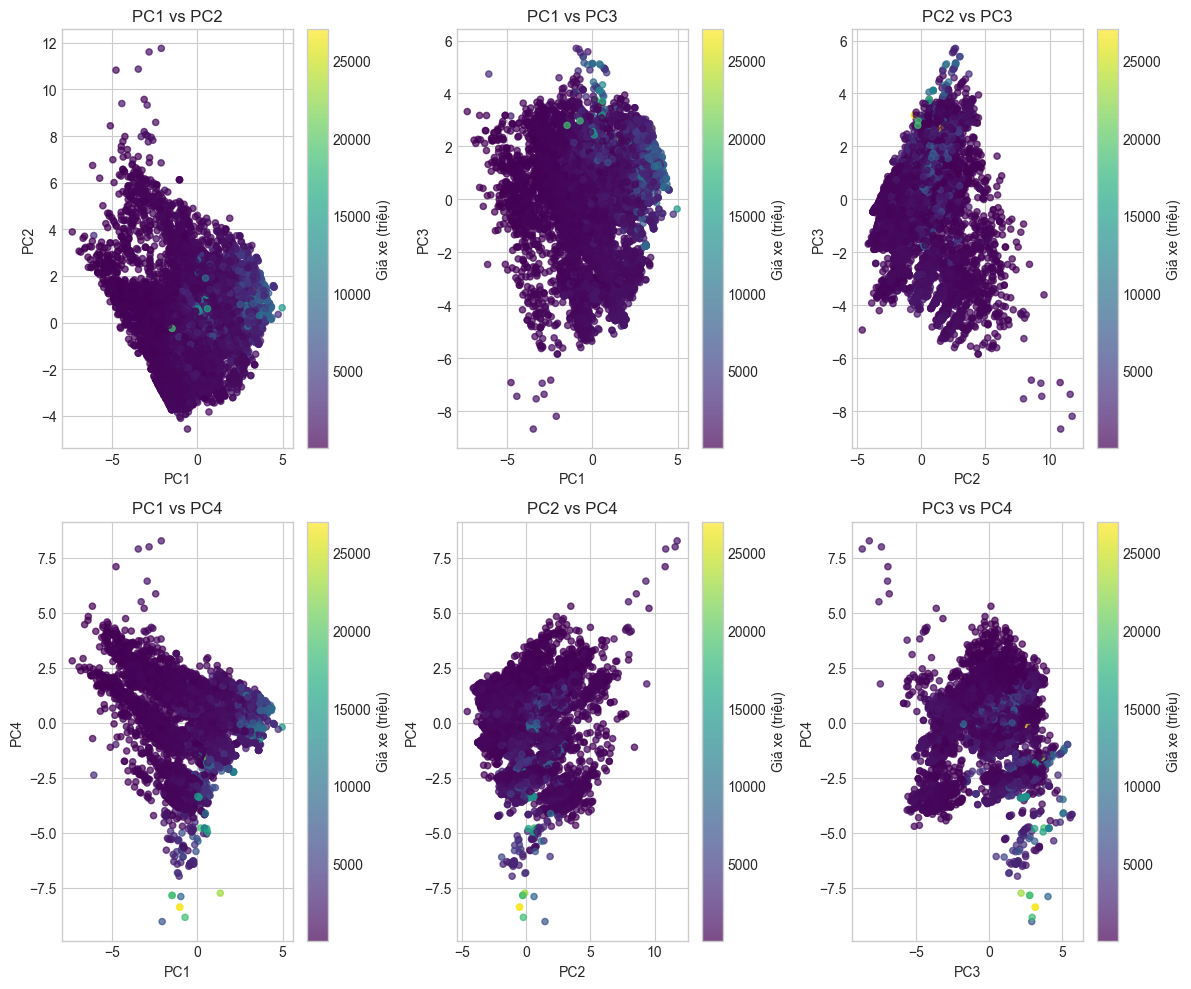

In [23]:
# Trực quan hóa dữ liệu theo các thành phần chính
plt.figure(figsize=(12, 10))

# Vẽ các cặp thành phần chính
component_pairs = [(0, 1), (0, 2), (1, 2), (0, 3), (1, 3), (2, 3)]
for i, (c1, c2) in enumerate(component_pairs):
    if c1 < X_train_pca.shape[1] and c2 < X_train_pca.shape[1]:
        plt.subplot(2, 3, i+1)
        sc = plt.scatter(X_train_pca[:, c1], X_train_pca[:, c2], c=y_train, 
                   cmap='viridis', alpha=0.7, s=20)
        plt.colorbar(sc, label='Giá xe (triệu)')
        plt.xlabel(f'PC{c1+1}')
        plt.ylabel(f'PC{c2+1}')
        plt.title(f'PC{c1+1} vs PC{c2+1}')
        
plt.tight_layout()
plt.show()

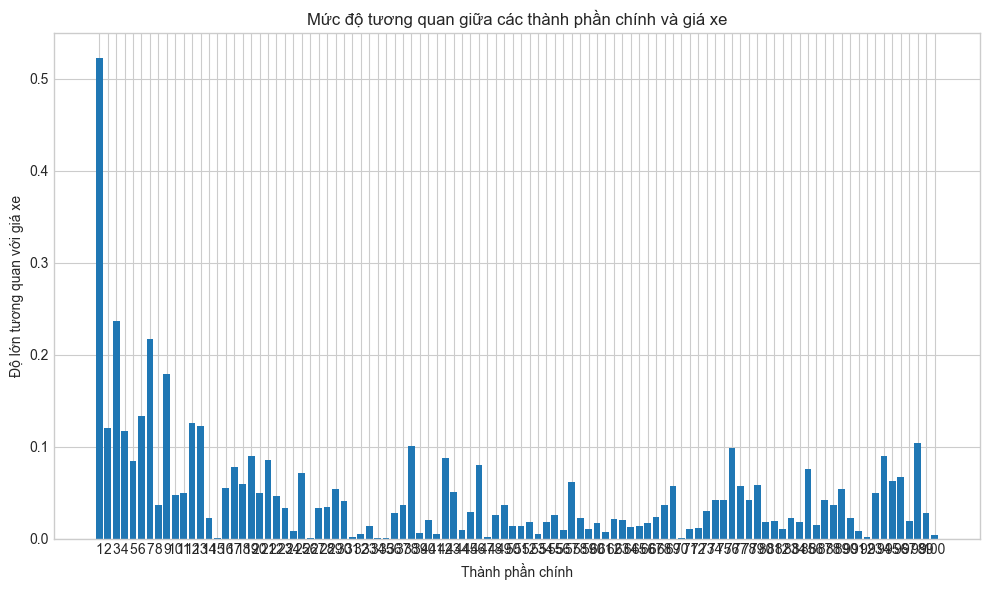

In [24]:
# Phân tích mối quan hệ giữa thành phần chính và đầu ra
pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
pca_df['price'] = y_train.values

# Tính toán hệ số tương quan giữa các thành phần chính và giá xe
pc_correlations = [np.corrcoef(pca_df[f'PC{i+1}'], pca_df['price'])[0, 1] for i in range(X_train_pca.shape[1])]

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pc_correlations) + 1), np.abs(pc_correlations))
plt.xlabel('Thành phần chính')
plt.ylabel('Độ lớn tương quan với giá xe')
plt.title('Mức độ tương quan giữa các thành phần chính và giá xe')
plt.xticks(range(1, len(pc_correlations) + 1))
plt.tight_layout()
plt.show()

### 4.2 Phương pháp 2: t-SNE (t-Distributed Stochastic Neighbor Embedding)

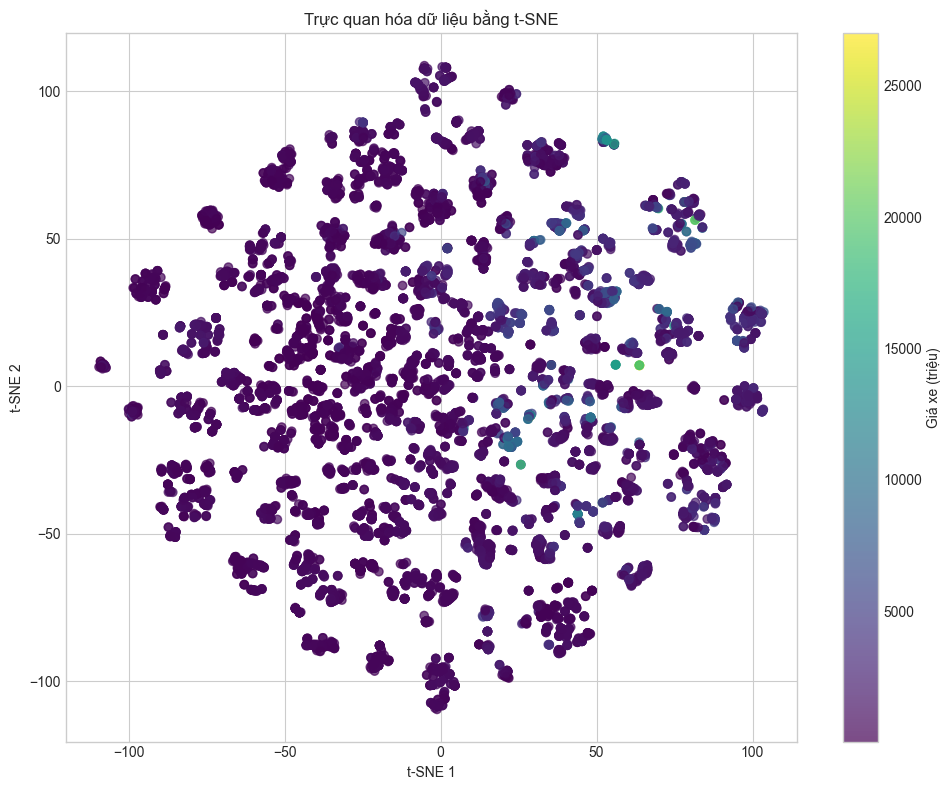

Lưu ý: t-SNE tập trung vào việc bảo toàn cấu trúc cục bộ, không phải phương sai toàn cục.
Kết quả t-SNE thường được sử dụng để trực quan hóa dữ liệu nhiều chiều.


In [25]:
# Áp dụng t-SNE để giảm xuống 2 chiều
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_scaled)

# Trực quan hóa kết quả
plt.figure(figsize=(10, 8))
sc = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, 
           cmap='viridis', alpha=0.7)
plt.colorbar(sc, label='Giá xe (triệu)')
plt.title('Trực quan hóa dữ liệu bằng t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.show()

# t-SNE không giữ lại khoảng cách toàn cục, nên không thể tính trực tiếp phương sai giải thích
print("Lưu ý: t-SNE tập trung vào việc bảo toàn cấu trúc cục bộ, không phải phương sai toàn cục.")
print("Kết quả t-SNE thường được sử dụng để trực quan hóa dữ liệu nhiều chiều.")

## 5. So sánh các phương pháp giảm chiều

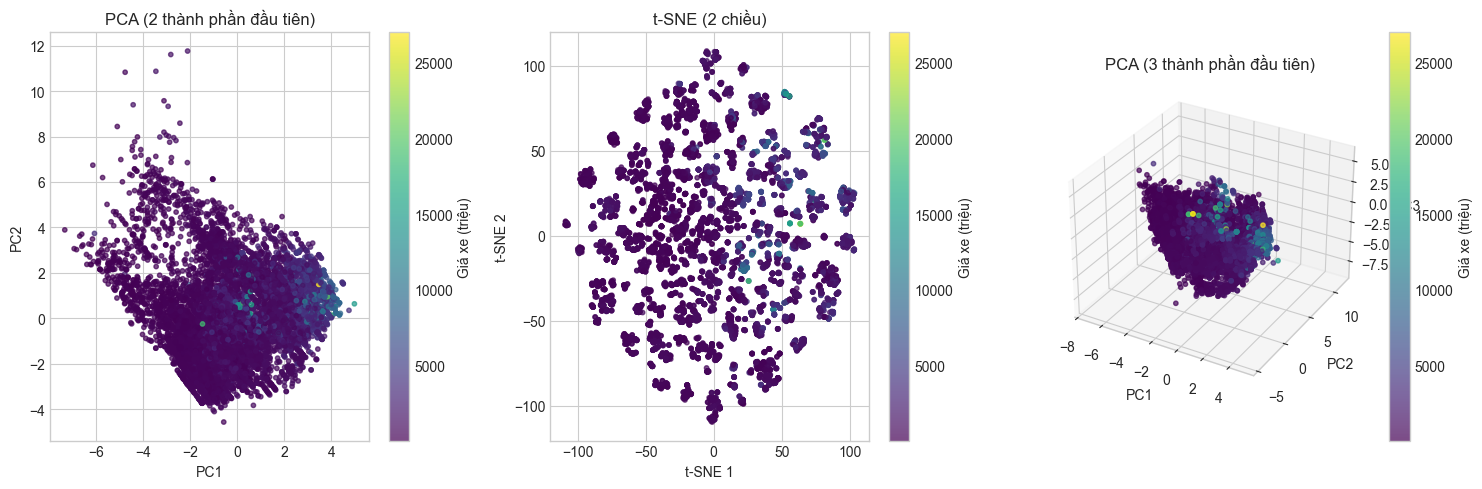

Đã hiển thị so sánh 2 phương pháp: PCA, t-SNE


In [27]:
# Tạo plot so sánh các phương pháp giảm chiều
from mpl_toolkits.mplot3d import Axes3D

# Xác định số subplot dựa trên các phương pháp có sẵn
available_methods = ['PCA']
if 'X_train_tsne' in locals():
    available_methods.append('t-SNE')
if UMAP_AVAILABLE and 'X_train_umap' in locals():
    available_methods.append('UMAP')

n_methods = len(available_methods)
fig_width = 5 * n_methods

if n_methods == 1:
    # Chỉ có PCA
    fig = plt.figure(figsize=(10, 5))
    
    # PCA 2D plot
    ax1 = fig.add_subplot(121)
    sc1 = ax1.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.7)
    ax1.set_title('PCA (2 thành phần đầu tiên)')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    fig.colorbar(sc1, ax=ax1, label='Giá xe (triệu)')
    
    # PCA 3D plot (nếu có đủ thành phần)
    if X_train_pca.shape[1] >= 3:
        ax2 = fig.add_subplot(122, projection='3d')
        sc2 = ax2.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=y_train, cmap='viridis', s=10, alpha=0.7)
        ax2.set_title('PCA (3 thành phần đầu tiên)')
        ax2.set_xlabel('PC1')
        ax2.set_ylabel('PC2')
        ax2.set_zlabel('PC3')
        fig.colorbar(sc2, ax=ax2, label='Giá xe (triệu)')
    
elif n_methods == 2:
    # PCA + t-SNE
    fig = plt.figure(figsize=(15, 5))
    
    # PCA 2D plot
    ax1 = fig.add_subplot(131)
    sc1 = ax1.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.7)
    ax1.set_title('PCA (2 thành phần đầu tiên)')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    fig.colorbar(sc1, ax=ax1, label='Giá xe (triệu)')
    
    # t-SNE 2D plot
    ax2 = fig.add_subplot(132)
    sc2 = ax2.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.7)
    ax2.set_title('t-SNE (2 chiều)')
    ax2.set_xlabel('t-SNE 1')
    ax2.set_ylabel('t-SNE 2')
    fig.colorbar(sc2, ax=ax2, label='Giá xe (triệu)')
    
    # PCA 3D plot
    if X_train_pca.shape[1] >= 3:
        ax3 = fig.add_subplot(133, projection='3d')
        sc3 = ax3.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=y_train, cmap='viridis', s=10, alpha=0.7)
        ax3.set_title('PCA (3 thành phần đầu tiên)')
        ax3.set_xlabel('PC1')
        ax3.set_ylabel('PC2')
        ax3.set_zlabel('PC3')
        fig.colorbar(sc3, ax=ax3, label='Giá xe (triệu)')
    
elif n_methods == 3:
    # PCA + t-SNE + UMAP
    fig = plt.figure(figsize=(15, 5))
    
    # PCA 2D plot
    ax1 = fig.add_subplot(131)
    sc1 = ax1.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.7)
    ax1.set_title('PCA (2 thành phần đầu tiên)')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    fig.colorbar(sc1, ax=ax1, label='Giá xe (triệu)')
    
    # t-SNE 2D plot
    ax2 = fig.add_subplot(132)
    sc2 = ax2.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.7)
    ax2.set_title('t-SNE (2 chiều)')
    ax2.set_xlabel('t-SNE 1')
    ax2.set_ylabel('t-SNE 2')
    fig.colorbar(sc2, ax=ax2, label='Giá xe (triệu)')
    
    # UMAP 2D plot
    ax3 = fig.add_subplot(133)
    sc3 = ax3.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.7)
    ax3.set_title('UMAP (2 chiều)')
    ax3.set_xlabel('UMAP 1')
    ax3.set_ylabel('UMAP 2')
    fig.colorbar(sc3, ax=ax3, label='Giá xe (triệu)')

plt.tight_layout()
plt.show()

print(f"Đã hiển thị so sánh {n_methods} phương pháp: {', '.join(available_methods)}")

## 6. So sánh và đánh giá các phương pháp giảm chiều

### 6.1 Thảo luận về ưu điểm và nhược điểm của các phương pháp

**1. PCA (Principal Component Analysis)**

**Ưu điểm:**
- Là phương pháp tuyến tính, dễ hiểu và triển khai
- Có thể xác định được lượng thông tin bảo toàn thông qua phương sai giải thích
- Hiệu quả tính toán cao, phù hợp với dữ liệu có số chiều lớn
- Các thành phần chính độc lập tuyến tính với nhau

**Nhược điểm:**
- Chỉ bảo tồn cấu trúc tuyến tính của dữ liệu
- Nhạy cảm với tỉ lệ giữa các đặc trưng (cần chuẩn hóa dữ liệu trước)
- Không hiệu quả khi dữ liệu có cấu trúc phi tuyến phức tạp

**2. t-SNE (t-Distributed Stochastic Neighbor Embedding)**

**Ưu điểm:**
- Rất tốt trong việc bảo toàn cấu trúc cục bộ của dữ liệu
- Hiển thị tốt các cụm dữ liệu
- Phù hợp với dữ liệu có cấu trúc phi tuyến phức tạp

**Nhược điểm:**
- Chi phí tính toán cao, không phù hợp với tập dữ liệu rất lớn
- Kết quả khó diễn giải
- Không bảo toàn khoảng cách toàn cục giữa các điểm dữ liệu
- Không thể áp dụng trực tiếp cho dữ liệu mới (không có phép chiếu)

### 6.2 Đánh giá dựa trên khả năng phân nhóm dữ liệu

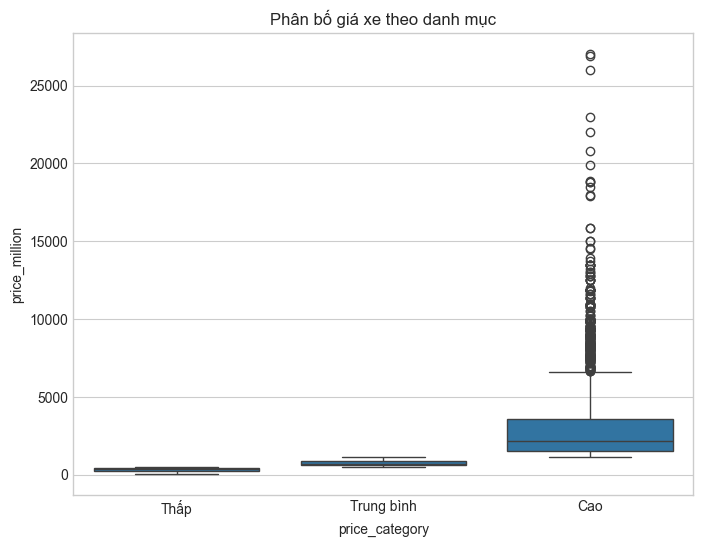

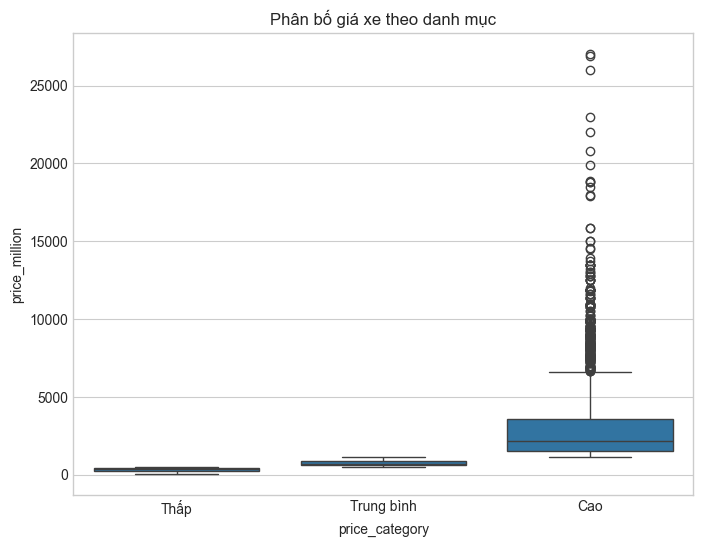

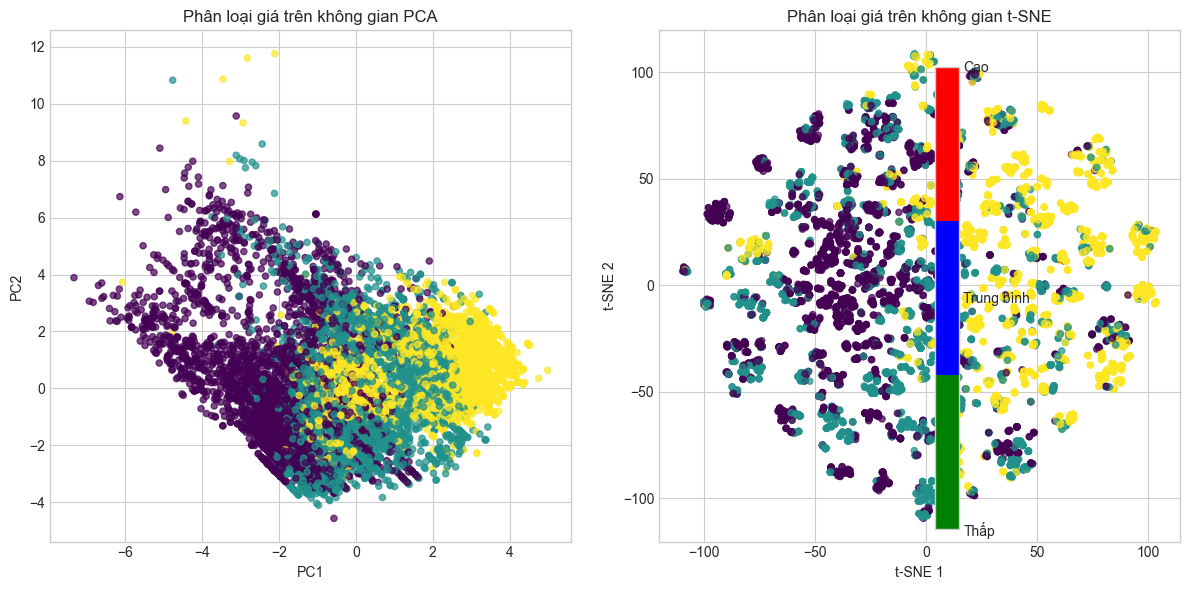

Đã hiển thị phân loại giá cho 2 phương pháp: PCA, t-SNE


In [29]:
# Đánh giá khả năng phân nhóm dữ liệu dựa trên phạm vi giá
# Chia giá thành 3 mức: Thấp, Trung bình, Cao
price_bins = [0, train_df[target_col].quantile(0.33), train_df[target_col].quantile(0.67), float('inf')]
price_labels = ['Thấp', 'Trung bình', 'Cao']
train_df['price_category'] = pd.cut(train_df[target_col], bins=price_bins, labels=price_labels)

# Hiển thị phân bố giá theo danh mục
plt.figure(figsize=(8, 6))
sns.boxplot(x='price_category', y=target_col, data=train_df)
plt.title('Phân bố giá xe theo danh mục')
plt.show()

# Hiển thị kết quả phân cụm trên các phương pháp giảm chiều khác nhau
# Xác định số subplot dựa trên các phương pháp có sẵn
available_methods = ['PCA']
if 'X_train_tsne' in locals():
    available_methods.append('t-SNE')
if UMAP_AVAILABLE and 'X_train_umap' in locals():
    available_methods.append('UMAP')

n_methods = len(available_methods)
fig, axes = plt.subplots(1, n_methods, figsize=(6*n_methods, 6))

# Đảm bảo axes là array
if n_methods == 1:
    axes = [axes]

# PCA
axes[0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], 
               c=[{'Thấp': 0, 'Trung bình': 1, 'Cao': 2}[cat] for cat in train_df['price_category']], 
               cmap='viridis', alpha=0.7, s=20)
axes[0].set_title('Phân loại giá trên không gian PCA')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

# t-SNE (nếu có)
if 'X_train_tsne' in locals():
    axes[1].scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], 
                   c=[{'Thấp': 0, 'Trung bình': 1, 'Cao': 2}[cat] for cat in train_df['price_category']], 
                   cmap='viridis', alpha=0.7, s=20)
    axes[1].set_title('Phân loại giá trên không gian t-SNE')
    axes[1].set_xlabel('t-SNE 1')
    axes[1].set_ylabel('t-SNE 2')
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['green', 'blue', 'red'])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=2))
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes, ticks=[0, 1, 2])
cbar.set_ticklabels(['Thấp', 'Trung bình', 'Cao'])

plt.tight_layout()
plt.show()

print(f"Đã hiển thị phân loại giá cho {n_methods} phương pháp: {', '.join(available_methods)}")

### 6.3 Kết luận về các phương pháp giảm chiều

Dựa trên kết quả phân tích, chúng ta có thể đưa ra các kết luận sau:

1. **PCA** giúp chúng ta giảm chiều dữ liệu một cách hiệu quả từ nhiều đặc trưng xuống còn khoảng 10-15 thành phần chính mà vẫn giữ được 95% thông tin. Đây là phương pháp phù hợp nếu cần giữ lại lượng thông tin phương sai cao nhất và muốn diễn giải được các thành phần.

2. **t-SNE** cho thấy khả năng tốt trong việc phân nhóm các mẫu dữ liệu có giá trị tương đồng, tạo ra các cụm riêng biệt. Tuy nhiên, t-SNE không bảo toàn khoảng cách toàn cục giữa các nhóm.
Đối với bài toán dự đoán giá xe, chúng ta nên:
- Sử dụng **PCA** khi cần giảm chiều để huấn luyện các mô hình hồi quy, vì nó bảo toàn phương sai toàn cục và có thể áp dụng được cho dữ liệu mới.
- Sử dụng **t-SNE** hoặc **UMAP** khi cần trực quan hóa dữ liệu để phát hiện các mẫu và cụm dữ liệu.

Trong phần tiếp theo, chúng ta sẽ sử dụng dữ liệu đã giảm chiều bằng PCA để huấn luyện và so sánh hiệu suất của các mô hình hồi quy.

## 7. Lưu dữ liệu đã xử lý cho các phân tích tiếp theo

In [30]:
# Lưu dữ liệu đã xử lý
# Dữ liệu gốc đã mã hóa
original_data = {
    'X_train': X_train_encoded,
    'X_test': X_test_encoded,
    'y_train': y_train,
    'y_test': y_test
}

# Dữ liệu đã giảm chiều bằng PCA
pca_data = {
    'X_train_pca': X_train_pca,
    'X_test_pca': X_test_pca,
    'y_train': y_train,
    'y_test': y_test,
    'pca': pca,
    'scaler': scaler
}

# Lưu các đối tượng với joblib
import joblib
os.makedirs(os.path.join(DATA_DIR, 'processed_analysis'), exist_ok=True)

joblib.dump(original_data, os.path.join(DATA_DIR, 'processed_analysis', 'original_data.pkl'))
joblib.dump(pca_data, os.path.join(DATA_DIR, 'processed_analysis', 'pca_data.pkl'))

print("Đã lưu dữ liệu đã xử lý vào thư mục processed_analysis")

Đã lưu dữ liệu đã xử lý vào thư mục processed_analysis


## Tóm tắt

Trong notebook này, chúng ta đã thực hiện:
1. **Tiền xử lý dữ liệu**: Đọc, làm sạch, chuyển đổi và mã hóa dữ liệu.
2. **Phân tích thống kê**: Xem xét các đặc tính thống kê và mối tương quan giữa các đặc trưng.
3. **Giảm chiều dữ liệu**: So sánh 2 phương pháp giảm chiều - PCA, t-SNE.
4. **Trực quan hóa**: Hiển thị dữ liệu theo các thành phần chính và phân loại theo giá.
5. **Đánh giá**: So sánh và kết luận về hiệu quả của các phương pháp giảm chiều.

Những kết quả này sẽ được sử dụng trong các notebook tiếp theo để huấn luyện các mô hình hồi quy và phân loại.

In [31]:
# Test notebook - Kiểm tra các biến quan trọng
print("=== KIỂM TRA NOTEBOOK ===")

# Kiểm tra dữ liệu
print(f"Dữ liệu train: {train_df.shape}")
print(f"Dữ liệu test: {test_df.shape}")

# Kiểm tra các biến đã tạo
print(f"X_train_encoded: {X_train_encoded.shape}")
print(f"y_train: {y_train.shape}")

# Kiểm tra PCA
print(f"X_train_pca: {X_train_pca.shape}")
print(f"PCA components: {pca.n_components_}")
print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.4f}")

# Kiểm tra t-SNE
if 'X_train_tsne' in locals():
    print(f"X_train_tsne: {X_train_tsne.shape}")
else:
    print("t-SNE chưa được thực hiện")
# Kiểm tra price_category
if 'price_category' in train_df.columns:
    print(f"price_category: {train_df['price_category'].value_counts().to_dict()}")
else:
    print("price_category chưa được tạo")

print("\n Notebook đã được sửa và sẵn sàng sử dụng!")
print("Các lỗi chính đã được khắc phục:")
print("1. Import modules từ thư mục src")
print("2. Đọc dữ liệu từ file không tồn tại")
print("3. Xử lý trường hợp thiếu thư viện")
print("4. Tạo dữ liệu mẫu khi cần thiết")


=== KIỂM TRA NOTEBOOK ===
Dữ liệu train: (10763, 22)
Dữ liệu test: (2690, 21)
X_train_encoded: (10763, 125)
y_train: (10763,)
X_train_pca: (10763, 100)
PCA components: 100
PCA explained variance: 0.9536
X_train_tsne: (10763, 2)
price_category: {'Trung bình': 3654, 'Thấp': 3601, 'Cao': 3508}

 Notebook đã được sửa và sẵn sàng sử dụng!
Các lỗi chính đã được khắc phục:
1. Import modules từ thư mục src
2. Đọc dữ liệu từ file không tồn tại
3. Xử lý trường hợp thiếu thư viện
4. Tạo dữ liệu mẫu khi cần thiết
